# Diptera wing classification using Topological Data Analysis

Guilherme Vituri F. Pinto [](https://orcid.org/0000-0002-7813-8777) (Universidade Estadual Paulista)  
Sergio UraNorthonFebruary 24, 2026

We apply tools from Topological Data Analysis (TDA) to classify Diptera families based on wing venation patterns. Using multiple filtration strategies — Vietoris-Rips on point clouds, directional height filtrations (8 directions), radial filtrations, Euclidean Distance Transform filtrations, and grayscale sublevel-set (cubical) filtrations on wing images — we extract both H0 and H1 topological features (persistence images, Betti curves, persistence landscapes and summary statistics) and compare distance-based and feature-based classifiers via leave-one-out cross-validation. Feature selection via Random Forest importance and nested LOOCV provide honest, unbiased accuracy estimates.

In [2]:
using TDAfly, TDAfly.Preprocessing, TDAfly.TDA, TDAfly.Analysis
using Images: mosaicview, Gray
using Plots: plot, display, heatmap, scatter, bar
using StatsPlots: boxplot
using PersistenceDiagrams
using PersistenceDiagrams: BettiCurve, Landscape, PersistenceImage
using DataFrames
using Distances: euclidean
using LIBSVM
using StatsBase: mean

## Introduction

The order Diptera (true flies) comprises over 150,000 described species across more than 150 families. Wing venation patterns are a classical diagnostic character in Diptera systematics: the arrangement, branching and connectivity of veins varies markedly across families and provides a natural morphological signature.

In this work, we apply **Topological Data Analysis (TDA)** to the problem of classifying Diptera families from wing images. TDA provides a framework for extracting shape descriptors that are robust to continuous deformations — exactly the kind of invariance desirable when comparing biological structures that vary in scale, orientation and minor deformations across individuals.

We employ five complementary filtration strategies:

1.  **Vietoris-Rips filtration** on point-cloud samples of wing silhouettes
2.  **Directional height filtrations** (8 directions) that sweep across the wing along different axes
3.  **Radial filtration** from the wing centroid to the periphery
4.  **Euclidean Distance Transform (EDT) filtration** capturing vein thickness hierarchy
5.  **Grayscale sublevel-set (cubical) filtration** on the raw wing image

For each filtration, we compute both **H0** (connected components / vein branching) and **H1** (loops / enclosed cells) persistence, then vectorize into feature representations (persistence images, Betti curves, persistence landscapes) and feed into classifiers. Feature selection and nested cross-validation provide honest accuracy estimates.

## Methods

### Data loading and preprocessing

All images are in the `images/processed` directory. For each image, we load it, apply a Gaussian blur (to close small gaps in the wing membrane and keep it connected), crop to the bounding box, and resize to 150 pixels of height.

In [3]:
all_paths = readdir("images/processed", join = true)
all_filenames = basename.(all_paths) .|> (x -> replace(x, ".png" => ""))

function extract_family(name)
    family_raw = lowercase(split(name, r"[\s\-]")[1])
    if family_raw in ("bibionidae", "biobionidae")
        return "Bibionidae"
    elseif family_raw in ("sciaridae", "scaridae")
        return "Sciaridae"
    elseif family_raw == "simulidae"
        return "Simuliidae"
    else
        return titlecase(family_raw)
    end
end

function canonical_id(name)
    family = extract_family(name)
    parts = split(name, r"[\s\-]")
    number = parts[end]
    "$(family)-$(number)"
end

# Deduplicate (space vs hyphen variants of the same file)
seen = Set{String}()
keep_idx = Int[]
for (i, fname) in enumerate(all_filenames)
    cid = canonical_id(fname)
    if !(cid in seen)
        push!(seen, cid)
        push!(keep_idx, i)
    end
end

paths = all_paths[keep_idx]
species = all_filenames[keep_idx]
families = extract_family.(species)

individuals = map(species) do specie
    parts = split(specie, r"[\s\-]")
    string(extract_family(specie)[1]) * "-" * parts[end]
end

println("Total images after deduplication: $(length(paths))")
println("Families: ", sort(unique(families)))
println("\nSamples per family:")
for f in sort(unique(families))
    println("  $(f): $(count(==(f), families))")
end

Total images after deduplication: 72
Families: ["Asilidae", "Bibionidae", "Ceratopogonidae", "Chironomidae", "Pelecorhynchidae", "Rhagionidae", "Sciaridae", "Simuliidae", "Tabanidae", "Tipulidae"]

Samples per family:
  Asilidae: 8
  Bibionidae: 6
  Ceratopogonidae: 8
  Chironomidae: 8
  Pelecorhynchidae: 2
  Rhagionidae: 4
  Sciaridae: 6
  Simuliidae: 7
  Tabanidae: 11
  Tipulidae: 12

#### Excluding small families

Families with fewer than 3 samples (e.g. Pelecorhynchidae with $n=2$) can distort cross-validation results—a single misclassification changes accuracy by 50%. We provide a filtered version and run the analysis both ways.

In [4]:
MIN_FAMILY_SIZE = 3
family_counts = Dict(f => count(==(f), families) for f in unique(families))
small_families = [f for (f, c) in family_counts if c < MIN_FAMILY_SIZE]

if !isempty(small_families)
    println("Families with < $MIN_FAMILY_SIZE samples (excluded from filtered analysis):")
    for f in sort(small_families)
        println("  $(f): $(family_counts[f]) samples")
    end
end

# Build filtered indices
keep_filtered = [i for i in eachindex(families) if family_counts[families[i]] >= MIN_FAMILY_SIZE]
paths_filtered = paths[keep_filtered]
species_filtered = species[keep_filtered]
families_filtered = families[keep_filtered]
individuals_filtered = individuals[keep_filtered]

println("\nFiltered dataset: $(length(keep_filtered)) samples, $(length(unique(families_filtered))) families")

Families with < 3 samples (excluded from filtered analysis):
  Pelecorhynchidae: 2 samples

Filtered dataset: 70 samples, 9 families

In [5]:
wings = load_wing.(paths, blur = 1.3)
Xs = map(wings) do w
    image_to_r2(w; ensure_connected = true, connectivity = 8)
end;


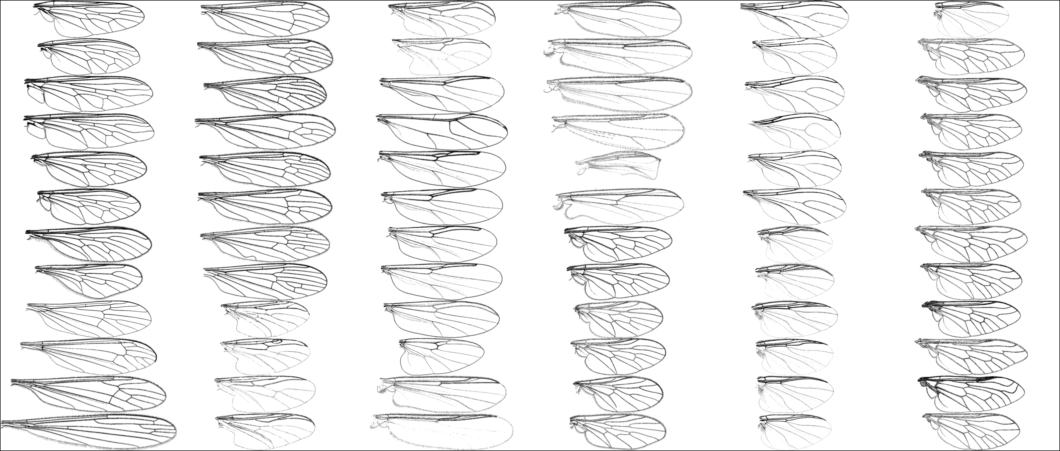

In [6]:
mosaicview(wings, ncol = 6, fillvalue = 1)

### Example: forcing connectivity on 5 wings

The chunk below selects 5 wings (prioritizing those with the largest number of disconnected components before correction), then compares the binary pixel set before and after `connect_pixel_components`.

In [7]:
threshold_conn = 0.2
conn = 8

component_count_before = map(wings) do w
    ids0 = findall_ids(>(threshold_conn), image_to_array(w))
    length(pixel_components(ids0; connectivity = conn))
end

demo_idx = sortperm(component_count_before, rev = true)[1:min(5, length(wings))]

function ids_to_mask(ids)
    isempty(ids) && return zeros(Float32, 1, 1)
    xs = first.(ids)
    ys = last.(ids)
    M = zeros(Float32, maximum(xs), maximum(ys))
    for p in ids
        M[p[1], p[2]] = 1f0
    end
    M
end

demo_connectivity_df = DataFrame(
    sample = String[],
    n_components_before = Int[],
    n_components_after = Int[],
    n_pixels_before = Int[],
    n_pixels_after = Int[],
)

panel_plots = Any[]
for idx in demo_idx
    ids_before = findall_ids(>(threshold_conn), image_to_array(wings[idx]))
    ids_after = connect_pixel_components(ids_before; connectivity = conn)

    n_before = length(pixel_components(ids_before; connectivity = conn))
    n_after = length(pixel_components(ids_after; connectivity = conn))

    push!(demo_connectivity_df, (
        species[idx],
        n_before,
        n_after,
        length(ids_before),
        length(ids_after),
    ))

    M_before = ids_to_mask(ids_before)
    M_after = ids_to_mask(ids_after)

    p_before = heatmap(
        M_before[end:-1:1, :],
        color = :grays,
        colorbar = false,
        legend = false,
        aspect_ratio = :equal,
        xticks = false,
        yticks = false,
        title = "Before: $(species[idx])\ncomponents = $(n_before)",
    )

    p_after = heatmap(
        M_after[end:-1:1, :],
        color = :grays,
        colorbar = false,
        legend = false,
        aspect_ratio = :equal,
        xticks = false,
        yticks = false,
        title = "After: $(species[idx])\ncomponents = $(n_after)",
    )

    push!(panel_plots, p_before)
    push!(panel_plots, p_after)
end

plot(panel_plots..., layout = (length(demo_idx), 2), size = (900, 260 * length(demo_idx)))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<path clip-path="url(#clip950)" d="M445.772 64.8611 L445.772 87.0195 L458.897 87.0195 Q465.5 87.0195 468.66 84.3054 Q471.86 81.5508 471.86 75.92 Q471.86 70.2488 468.66 67.5752 Q465.5 64.8611 458.897 64.8611 L445.772 64.8611 M445.772 39.9885 L445.772 58.2176 L457.884 58.2176 Q463.88 58.2176 466.796 55.9896 Q469.753 53.7211 469.753 49.103 Q469.753 44.5255 466.796 42.257 Q463.88 39.9885 457.884 39.9885 L445.772 39.9885 M437.589 33.264 L458.492 33.264 Q467.85 33.264 472.913 37.1529 Q477.977 41.0417 477.977 48.2118 Q477.977 53.7616 475.384 57.0428 Q472.792 60.324 467.769 61.1342 Q473.804 62.4305 477.126 66.5624 Q480.488 70.6538 480.488 76.8112 Q480.488 84.913 474.979 89.3285 Q469.47 93.744 459.302 93.744 L437.589 93.744 L437.589 33.264 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip950)" d="M532.988 69.1955 L532.988 72.8413 L498.717 72.8413 Q499.204 80.5381 503.335 84.589 Q507.508 88.5994 514.921 88.5994 Q519.215 88.5994 523.225 87.5461 Q527.276 86.4929 531.246 84.3864 L531.246 91.435 Q527.236 93.1364 523.023 94.0276 Q518.81 94.9188 514.475 94.9188 Q503.619 94.9188 497.259 88.5994 Q490.94 82.2799 490.94 71.5045 Q490.94 60.3645 496.935 53.8426 Q502.971 47.2801 513.179 47.2801 Q522.334 47.2801 527.641 53.1944 Q532.988 59.0683 532.988 69.1955 M525.534 67.008 Q525.453 60.8912 522.091 57.2454 Q518.769 53.5995 513.26 53.5995 Q507.022 53.5995 503.254 57.1238 Q499.528 60.6481 498.96 67.0485 L525.534 67.008 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip950)" d="M592.01 53.5995 Q586.014 53.5995 582.531 58.2986 Q579.047 62.9571 579.047 71.0994 Q579.047 79.2418 582.49 83.9408 Q585.974 88.5994 592.01 88.5994 Q597.965 88.5994 601.448 83.9003 Q604.932 79.2013 604.932 71.0994 Q604.932 63.0381 601.448 58.3391 Q597.965 53.5995 592.01 53.5995 M592.01 47.2801 Q601.732 47.2801 607.282 53.5995 Q612.831 59.9189 612.831 71.0994 Q612.831 82.2394 607.282 88.5994 Q601.732 94.9188 592.01 94.9188 Q582.247 94.9188 576.697 88.5994 Q571.188 82.2394 571.188 71.0994 Q571.188 59.9189 576.697 53.5995 Q582.247 47.2801 592.01 47.2801 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip950)" d="M696.28 69.1955 L696.28 72.8413 L662.009 72.8413 Q662.495 80.5381 666.627 84.589 Q670.8 88.5994 678.213 88.5994 Q682.507 88.5994 686.517 87.5461 Q690.568 86.4929 694.538 84.3864 L694.538 91.435 Q690.528 93.1364 686.315 94.0276 Q682.102 94.9188 677.767 94.9188 Q666.911 94.9188 660.551 88.5994 Q654.232 82.2799 654.232 71.5045 Q654.232 60.3645 660.227 53.8426 Q666.263 47.2801 676.471 47.2801 Q685.626 47.2801 690.933 53.1944 Q696.28 59.0683 696.28 69.1955 M688.826 67.008 Q688.745 60.8912 685.383 57.2454 Q682.061 53.5995 676.552 53.5995 Q670.314 53.5995 666.546 57.1238 Q662.82 60.6481 662.252 67.0485 L688.826 67.008 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip950)" d="M795.406 71.0994 Q795.406 62.8761 792.003 58.2176 Q788.641 53.5185 782.726 53.5185 Q776.812 53.5185 773.409 58.2176 Q770.047 62.8761 770.047 71.0994 Q770.047 79.3228 773.409 84.0218 Q776.812 88.6804 782.726 88.6804 Q788.641 88.6804 792.003 84.0218 Q795.406 79.3228 795.406 71.0994 M770.047 55.2604 Q772.397 51.2095 775.961 49.2651 Q779.567 47.2801 784.549 47.2801 Q792.813 47.2801 797.958 53.8426 Q803.143 60.4051 803.143 71.0994 Q803.143 81.7938 797.958 88.3563 Q792.813 94.9188 784.549 94.9188 Q779.567 94.9188 775.961 92.9743 Q772.397 90.9894 770.047 86.9385 L770.047 93.744 L762.553 93.744 L762.553 30.7119 L770.047 30.7119 L770.047 55.2604 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip950)" d="M856.129 53.5995 Q850.133 53.5995 846.65 58.2986 Q843.166 62.9571 843.166 71.0994 Q843.166 79.2418 846.609 83.9408 Q850.093 88.5994 856.129 88.5994 Q862.084 88.5994 865.567 83.9003 Q869.051 79.2013 869.051 71.0994 Q869.051 63.0381 865.567 58.3391 Q862.084 53.5995 856.129 53.59

In [8]:
demo_connectivity_df

## Topological feature extraction

We now compute persistent homology using five filtration strategies. For the Vietoris-Rips filtration on connected point clouds, H0 is uninformative (single infinite bar), so we use only H1. However, for cubical filtrations (directional, radial, EDT, grayscale), **H0 is highly informative** — it captures when disconnected vein segments merge as the filtration parameter grows, directly encoding vein count and branching patterns. We therefore compute both H0 and H1 for all cubical-based filtrations.

> **What is persistent homology?**
>
> Persistent homology is the main tool of TDA. Given a shape or dataset, it tracks how topological features — connected components (dimension 0), loops (dimension 1), voids (dimension 2), etc. — appear and disappear as we “grow” the shape through a filtration parameter. Each feature has a **birth** time (when it appears) and a **death** time (when it gets filled in). The collection of all (birth, death) pairs is called a **persistence diagram**. Features with long lifetimes (high persistence = death $-$ birth) represent genuine topological structure, while short-lived features are typically noise.

### Strategy 1: Vietoris-Rips filtration on point clouds

> **Vietoris-Rips filtration**
>
> Given a set of points in $\mathbb{R}^n$, the Vietoris-Rips complex at scale $\varepsilon$ connects any subset of points that are pairwise within distance $\varepsilon$. As $\varepsilon$ increases from 0, we obtain a nested sequence of simplicial complexes — the Rips filtration. This is the most common filtration in TDA for point-cloud data. It is computationally expensive (since it must consider all pairwise distances), which is why we subsample the point clouds.

We sample 750 points from each wing silhouette using farthest-point sampling (which ensures good coverage of the shape), then compute 1-dimensional Rips persistence:

In [9]:
samples = Vector{Any}(undef, length(Xs))
Threads.@threads for i in eachindex(Xs)
    samples[i] = farthest_points_sample(Xs[i], 750)
end

In [10]:
pds_rips = @showprogress map(samples) do s
    rips_pd_1d(s, cutoff = 5, threshold = 200)
end;

In [11]:
wing_arrays = [convert(Array{Float64}, w) for w in wings]

72-element Vector{Matrix{Float64}}:
 [1.0000000074505804 1.0000000074505804 … 1.0000000074505804 1.0000000074505804; 1.0000000074505804 1.0000000074505804 … 1.0000000074505804 1.0000000074505804; … ; 1.0000000074505804 1.0000000074505804 … 1.0000000074505804 1.0000000074505804; 1.0000000074505804 1.0000000074505804 … 1.0000000074505804 1.0000000074505804]
 [1.0000000074505804 1.0000000074505804 … 1.0000000074505804 1.0000000074505804; 1.0000000074505804 1.0000000074505804 … 1.0000000074505804 1.0000000074505804; … ; 1.0000000074505804 1.0000000074505804 … 1.0000000074505804 1.0000000074505804; 1.0000000074505804 1.0000000074505804 … 1.0000000074505804 1.0000000074505804]
 [1.0000000074505804 1.0000000074505804 … 1.0000000074505804 1.0000000074505804; 1.0000000074505804 1.0000000074505804 … 1.0000000074505804 1.0000000074505804; … ; 1.0000000074505804 1.0000000074505804 … 1.0000000074505804 1.0000000074505804; 1.0000000074505804 1.0000000074505804 … 1.0000000074505804 1.0000000074505804

### Strategy 2: Directional height filtrations

> **Directional (height) filtrations**
>
> A **height filtration** sweeps a hyperplane across the shape in a chosen direction and tracks topology as the “visible” region grows. For a direction vector $v$, we assign each foreground pixel the value $\langle (i,j), v \rangle$ (its projection onto $v$), then compute sublevel-set persistence. Different directions capture different geometric aspects: a horizontal sweep detects how vein loops are arranged from base to tip, a vertical sweep captures dorsal-ventral structure, and diagonal sweeps capture oblique patterns. Using multiple directions enriches the topological signature.

We compute persistence along **eight** directions (every 22.5°) to capture finer angular structure of vein branching, including oblique vein angles missed by 4 directions. For each direction, we extract both **H0** (connected component merging = vein branching) and **H1** (loop formation):

In [12]:
angles = range(0, π, length=9)[1:8]
directions = [[sin(θ), cos(θ)] for θ in angles]
direction_names = ["Dir_$(round(Int, rad2deg(θ)))°" for θ in angles]

println("Using $(length(directions)) directions:")
for (name, dir) in zip(direction_names, directions)
    println("  $name: $dir")
end

# H1 persistence (loops) — as before, but expanded to 8 directions
pds_directional = Dict{String, Vector}()
for (dir, name) in zip(directions, direction_names)
    pds_directional[name] = @showprogress "$name H1" map(wing_arrays) do A
        directional_pd_1d(A, dir)
    end
end

# H0 persistence (connected component merging = vein branching patterns)
pds_directional_h0 = Dict{String, Vector}()
for (dir, name) in zip(directions, direction_names)
    pds_directional_h0[name] = @showprogress "$name H0" map(wing_arrays) do A
        directional_pd_0d(A, dir)
    end
end;

Using 8 directions:
  Dir_0°: [0.0, 1.0]
  Dir_22°: [0.3826834323650898, 0.9238795325112867]
  Dir_45°: [0.7071067811865475, 0.7071067811865476]
  Dir_68°: [0.9238795325112867, 0.38268343236508984]
  Dir_90°: [1.0, 6.123233995736766e-17]
  Dir_112°: [0.9238795325112867, -0.3826834323650897]
  Dir_135°: [0.7071067811865476, -0.7071067811865475]
  Dir_158°: [0.3826834323650899, -0.9238795325112867]

### Strategy 3: Radial filtration

> **Radial filtration**
>
> The **radial filtration** assigns each foreground pixel a value equal to its distance from the centroid of the wing. Sublevel-set persistence on this function captures how topological features (loops in the venation) are distributed from the center of the wing outward. This is complementary to the directional filtrations.

In [13]:
pds_radial = @showprogress "radial_pd_1d" map(wing_arrays) do A
    radial_pd_1d(A)
end;

We also compute H0 persistence for the radial filtration, capturing how disconnected vein segments merge as the radial sweep grows outward:

In [14]:
pds_radial_h0 = @showprogress "radial_pd_0d" map(wing_arrays) do A
    radial_pd_0d(A)
end;

### Strategy 4: Euclidean Distance Transform (EDT) filtration

> **EDT filtration**
>
> The **Euclidean Distance Transform** assigns each foreground pixel the distance to the nearest background pixel. Thick veins get high EDT values. By negating the EDT as a filtration value, thick veins appear first in the sublevel-set filtration. This captures the **vein thickness hierarchy** — a diagnostic taxonomic character (e.g., Tabanidae have thickened costal and subcostal veins).

In [15]:
pds_edt_h1 = @showprogress "EDT H1" map(wing_arrays) do A
    edt_pd_1d(A)
end

pds_edt_h0 = @showprogress "EDT H0" map(wing_arrays) do A
    edt_pd_0d(A)
end;

### Strategy 5: Cubical (grayscale sublevel-set) persistence

> **Grayscale sublevel-set persistence**
>
> The function `cubical_pd` computes sublevel-set persistence directly on the grayscale wing image (inverted so that dark veins have low filtration values). This captures the intensity landscape of the wing image without any thresholding, preserving information about semi-transparent wing membrane regions and vein intensity gradients.

In [16]:
pds_cubical = @showprogress "Cubical" map(wing_arrays) do A
    cubical_pd(A; dim_max=1)
end

pds_cubical_h0 = [pd[1] for pd in pds_cubical]
pds_cubical_h1 = [pd[2] for pd in pds_cubical];

### Persistence vectorization

Raw persistence diagrams live in a space that is not directly amenable to standard machine learning. We vectorize them using three approaches:

> **Persistence images**
>
> A **persistence image** is a stable, finite-dimensional representation of a persistence diagram. Each point $(b, d)$ is mapped to $(b, d - b)$ coordinates (birth vs persistence), weighted by a function that emphasizes long-lived features, then smoothed with a Gaussian kernel and discretized onto a grid. The result is a matrix (image) that can be treated as a feature vector. Persistence images are stable with respect to the Wasserstein distance and have proven effective in machine learning pipelines.

> **Betti curves**
>
> The **Betti curve** $\beta_k(t)$ counts the number of $k$-dimensional features alive at filtration value $t$. For dimension 1, it counts the number of loops present at each scale. Discretized over a grid, it produces a feature vector. Betti curves are simple, interpretable, and capture the “topological complexity” of the shape at each scale.

> **Persistence landscapes**
>
> A **persistence landscape** is a sequence of piecewise-linear functions derived from a persistence diagram. The $k$-th landscape $\lambda_k$ is the $k$-th largest value of a collection of tent functions, one per interval. Landscapes live in a Banach space, which means we can compute means, perform hypothesis tests, and use them directly in statistical and machine learning methods. They provide a richer representation than Betti curves.

In [17]:
# Vectorize Rips persistence
PI_rips = PersistenceImage(pds_rips, size = (15, 15))
pi_rips = PI_rips.(pds_rips)

bc_rips = BettiCurve(pds_rips; length = 50)
betti_rips = bc_rips.(pds_rips)

land1_rips = Landscape(1, pds_rips; length = 50)
land2_rips = Landscape(2, pds_rips; length = 50)
land1_rips_vecs = land1_rips.(pds_rips)
land2_rips_vecs = land2_rips.(pds_rips);

In [18]:
# Vectorize directional persistence (H1)
pi_directional = Dict{String, Vector}()
betti_directional = Dict{String, Vector}()

for name in direction_names
    pds = pds_directional[name]
    PI_d = PersistenceImage(pds, size = (10, 10))
    pi_directional[name] = PI_d.(pds)

    bc_d = BettiCurve(pds; length = 30)
    betti_directional[name] = bc_d.(pds)
end

# Vectorize directional persistence (H0 — NEW)
pi_directional_h0 = Dict{String, Vector}()
betti_directional_h0 = Dict{String, Vector}()

for name in direction_names
    pds = pds_directional_h0[name]
    # Filter out infinite intervals for vectorization
    pds_finite = [filter(x -> isfinite(persistence(x)), pd) for pd in pds]
    if any(!isempty, pds_finite)
        PI_d0 = PersistenceImage(pds_finite, size = (10, 10))
        pi_directional_h0[name] = PI_d0.(pds_finite)
        bc_d0 = BettiCurve(pds_finite; length = 30)
        betti_directional_h0[name] = bc_d0.(pds_finite)
    else
        pi_directional_h0[name] = [zeros(10 * 10) for _ in pds]
        betti_directional_h0[name] = [zeros(30) for _ in pds]
    end
end

# Radial H1
PI_rad = PersistenceImage(pds_radial, size = (10, 10))
pi_radial = PI_rad.(pds_radial)

bc_rad = BettiCurve(pds_radial; length = 30)
betti_radial = bc_rad.(pds_radial)

# Radial H0 (NEW)
pds_radial_h0_finite = [filter(x -> isfinite(persistence(x)), pd) for pd in pds_radial_h0]
if any(!isempty, pds_radial_h0_finite)
    PI_rad_h0 = PersistenceImage(pds_radial_h0_finite, size = (10, 10))
    pi_radial_h0 = PI_rad_h0.(pds_radial_h0_finite)
    bc_rad_h0 = BettiCurve(pds_radial_h0_finite; length = 30)
    betti_radial_h0 = bc_rad_h0.(pds_radial_h0_finite)
else
    pi_radial_h0 = [zeros(10 * 10) for _ in pds_radial_h0]
    betti_radial_h0 = [zeros(30) for _ in pds_radial_h0]
end

# EDT H1 (NEW)
if any(!isempty, pds_edt_h1)
    PI_edt_h1 = PersistenceImage(pds_edt_h1, size = (10, 10))
    pi_edt_h1 = PI_edt_h1.(pds_edt_h1)
    bc_edt_h1 = BettiCurve(pds_edt_h1; length = 30)
    betti_edt_h1 = bc_edt_h1.(pds_edt_h1)
else
    pi_edt_h1 = [zeros(10 * 10) for _ in pds_edt_h1]
    betti_edt_h1 = [zeros(30) for _ in pds_edt_h1]
end

# EDT H0 (NEW)
pds_edt_h0_finite = [filter(x -> isfinite(persistence(x)), pd) for pd in pds_edt_h0]
if any(!isempty, pds_edt_h0_finite)
    PI_edt_h0 = PersistenceImage(pds_edt_h0_finite, size = (10, 10))
    pi_edt_h0 = PI_edt_h0.(pds_edt_h0_finite)
    bc_edt_h0 = BettiCurve(pds_edt_h0_finite; length = 30)
    betti_edt_h0 = bc_edt_h0.(pds_edt_h0_finite)
else
    pi_edt_h0 = [zeros(10 * 10) for _ in pds_edt_h0]
    betti_edt_h0 = [zeros(30) for _ in pds_edt_h0]
end

# Cubical H0 and H1 (NEW)
if any(!isempty, pds_cubical_h1)
    PI_cub_h1 = PersistenceImage(pds_cubical_h1, size = (10, 10))
    pi_cubical_h1 = PI_cub_h1.(pds_cubical_h1)
    bc_cub_h1 = BettiCurve(pds_cubical_h1; length = 30)
    betti_cubical_h1 = bc_cub_h1.(pds_cubical_h1)
else
    pi_cubical_h1 = [zeros(10 * 10) for _ in pds_cubical_h1]
    betti_cubical_h1 = [zeros(30) for _ in pds_cubical_h1]
end

pds_cubical_h0_finite = [filter(x -> isfinite(persistence(x)), pd) for pd in pds_cubical_h0]
if any(!isempty, pds_cubical_h0_finite)
    PI_cub_h0 = PersistenceImage(pds_cubical_h0_finite, size = (10, 10))
    pi_cubical_h0 = PI_cub_h0.(pds_cubical_h0_finite)
    bc_cub_h0 = BettiCurve(pds_cubical_h0_finite; length = 30)
    betti_cubical_h0 = bc_cub_h0.(pds_cubical_h0_finite)
else
    pi_cubical_h0 = [zeros(10 * 10) for _ in pds_cubical_h0]
    betti_cubical_h0 = [zeros(30) for _ in pds_cubical_h0]
end

println("Vectorization complete.")
println("  Directional: $(length(direction_names)) directions × H0 + H1")
println("  Radial: H0 + H1")
println("  EDT: H0 + H1")
println("  Cubical: H0 + H1");

Vectorization complete.
  Directional: 8 directions × H0 + H1
  Radial: H0 + H1
  EDT: H0 + H1
  Cubical: H0 + H1

### Examples

Below are examples of 1-dimensional persistence diagrams from each filtration strategy for one specimen per family:

In [19]:
example_indices = [findfirst(==(f), families) for f in sort(unique(families))]

for i in example_indices
    pers_rips = persistence.(pds_rips[i])
    pers_dir = persistence.(pds_directional[direction_names[1]][i])
    pers_rad = persistence.(pds_radial[i])
    pers_edt = persistence.(pds_edt_h1[i])

    p1 = isempty(pers_rips) ? plot(title = "Rips H₁ (empty)") :
         bar(sort(pers_rips, rev = true), title = "Rips H₁", legend = false, ylabel = "persistence")
    p2 = isempty(pers_dir) ? plot(title = "Dir 0° H₁ (empty)") :
         bar(sort(pers_dir, rev = true), title = "Dir 0° H₁", legend = false, ylabel = "persistence")
    p3 = isempty(pers_rad) ? plot(title = "Radial H₁ (empty)") :
         bar(sort(pers_rad, rev = true), title = "Radial H₁", legend = false, ylabel = "persistence")
    p4 = isempty(pers_edt) ? plot(title = "EDT H₁ (empty)") :
         bar(sort(pers_edt, rev = true), title = "EDT H₁", legend = false, ylabel = "persistence")
    p5 = scatter(last.(samples[i]), first.(samples[i]),
                 aspect_ratio = :equal, markersize = 1, legend = false, title = "Point cloud")

    # H0 examples
    pers_dir_h0 = [persistence(x) for x in pds_directional_h0[direction_names[1]][i] if isfinite(persistence(x))]
    p6 = isempty(pers_dir_h0) ? plot(title = "Dir 0° H₀ (empty)") :
         bar(sort(pers_dir_h0, rev = true), title = "Dir 0° H₀", legend = false, ylabel = "persistence")

    p = plot(p1, p2, p3, p4, p5, p6, layout = (3, 2), size = (900, 900),
             plot_title = "$(families[i]) ($(individuals[i]))")
    display(p)
end;

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<path clip-path="url(#clip070)" d="M297.122 1209.69 Q293.511 1209.69 291.682 1213.25 Q289.876 1216.79 289.876 1223.92 Q289.876 1231.03 291.682 1234.59 Q293.511 1238.14 297.122 1238.14 Q300.756 1238.14 302.561 1234.59 Q304.39 1231.03 304.39 1223.92 Q304.39 1216.79 302.561 1213.25 Q300.756 1209.69 297.122 1209.69 M297.122 1205.98 Q302.932 1205.98 305.987 1210.59 Q309.066 1215.17 309.066 1223.92 Q309.066 1232.65 305.987 1237.26 Q302.932 1241.84 297.122 1241.84 Q291.311 1241.84 288.233 1237.26 Q285.177 1232.65 285.177 1223.92 Q285.177 1215.17 288.233 1210.59 Q291.311 1205.98 297.122 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip070)" d="M623.983 1206.61 L642.34 1206.61 L642.34 1210.54 L628.266 1210.54 L628.266 1219.02 Q629.284 1218.67 630.303 1218.51 Q631.321 1218.32 632.34 1218.32 Q638.127 1218.32 641.507 1221.49 Q644.886 1224.66 644.886 1230.08 Q644.886 1235.66 641.414 1238.76 Q637.942 1241.84 631.622 1241.84 Q629.446 1241.84 627.178 1241.47 Q624.933 1241.1 622.525 1240.36 L622.525 1235.66 Q624.608 1236.79 626.831 1237.35 Q629.053 1237.9 631.53 1237.9 Q635.534 1237.9 637.872 1235.8 Q640.21 1233.69 640.21 1230.08 Q640.21 1226.47 637.872 1224.36 Q635.534 1222.26 631.53 1222.26 Q629.655 1222.26 627.78 1222.67 Q625.928 1223.09 623.983 1223.97 L623.983 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip070)" d="M984.329 1209.69 Q980.718 1209.69 978.889 1213.25 Q977.084 1216.79 977.084 1223.92 Q977.084 1231.03 978.889 1234.59 Q980.718 1238.14 984.329 1238.14 Q987.963 1238.14 989.769 1234.59 Q991.597 1231.03 991.597 1223.92 Q991.597 1216.79 989.769 1213.25 Q987.963 1209.69 984.329 1209.69 M984.329 1205.98 Q990.139 1205.98 993.195 1210.59 Q996.273 1215.17 996.273 1223.92 Q996.273 1232.65 993.195 1237.26 Q990.139 1241.84 984.329 1241.84 Q978.519 1241.84 975.44 1237.26 Q972.385 1232.65 972.385 1223.92 Q972.385 1215.17 975.44 1210.59 Q978.519 1205.98 984.329 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip070)" d="M1311.46 1206.61 L1329.81 1206.61 L1329.81 1210.54 L1315.74 1210.54 L1315.74 1219.02 Q1316.76 1218.67 1317.78 1218.51 Q1318.79 1218.32 1319.81 1218.32 Q1325.6 1218.32 1328.98 1221.49 Q1332.36 1224.66 1332.36 1230.08 Q1332.36 1235.66 1328.89 1238.76 Q1325.42 1241.84 1319.1 1241.84 Q1316.92 1241.84 1314.65 1241.47 Q1312.41 1241.1 1310 1240.36 L1310 1235.66 Q1312.08 1236.79 1314.3 1237.35 Q1316.53 1237.9 1319 1237.9 Q1323.01 1237.9 1325.35 1235.8 Q1327.68 1233.69 1327.68 1230.08 Q1327.68 1226.47 1325.35 1224.36 Q1323.01 1222.26 1319 1222.26 Q1317.13 1222.26 1315.25 1222.67 Q1313.4 1223.09 1311.46 1223.97 L1311.46 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip070)" d="M1622.23 1237.23 L1638.55 1237.23 L1638.55 1241.17 L1616.61 1241.17 L1616.61 1237.23 Q1619.27 1234.48 1623.85 1229.85 Q1628.46 1225.2 1629.64 1223.85 Q1631.88 1221.33 1632.76 1219.59 Q1633.67 1217.83 1633.67 1216.14 Q1633.67 1213.39 1631.72 1211.65 Q1629.8 1209.92 1626.7 1209.92 Q1624.5 1209.92 1622.05 1210.68 Q1619.62 1211.45 1616.84 1213 L1616.84 1208.27 Q1619.66 1207.14 1622.12 1206.56 Q1624.57 1205.98 1626.61 1205.98 Q1631.98 1205.98 1635.17 1208.67 Q1638.37 1211.35 1638.37 1215.84 Q1638.37 1217.97 1637.55 1219.89 Q1636.77 1221.79 1634.66 1224.39 Q1634.08 1225.06 1630.98 1228.27 Q1627.88 1231.47 1622.23 1237.23 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip070)" d="M1658.36 1209.69 Q1654.75 1209.69 1652.93 1213.25 Q1651.12 1216.79 1651.12 1223.92 Q1651.12 1231.03 1652.93 1234.59 Q1654.75 1238.14 1658.36 1238.14 Q1662 1238.14 1663.8 1234.59 Q1665.63 1231.03 1665.63 1223.92 Q1665.63 1216.79 1663.8 1213.25 Q1662 1209.69 1658.36 1209.69 M1658.36 1205.98 Q1664.18 1205.98 1667.23 1210.59 Q1670.31 1215.17 1670.31 1223.92 Q1670.31 1232.65 1667.23 1237.26 Q1664.

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<path clip-path="url(#clip190)" d="M252.418 1209.69 Q248.807 1209.69 246.978 1213.25 Q245.172 1216.79 245.172 1223.92 Q245.172 1231.03 246.978 1234.59 Q248.807 1238.14 252.418 1238.14 Q256.052 1238.14 257.857 1234.59 Q259.686 1231.03 259.686 1223.92 Q259.686 1216.79 257.857 1213.25 Q256.052 1209.69 252.418 1209.69 M252.418 1205.98 Q258.228 1205.98 261.283 1210.59 Q264.362 1215.17 264.362 1223.92 Q264.362 1232.65 261.283 1237.26 Q258.228 1241.84 252.418 1241.84 Q246.608 1241.84 243.529 1237.26 Q240.473 1232.65 240.473 1223.92 Q240.473 1215.17 243.529 1210.59 Q246.608 1205.98 252.418 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip190)" d="M297.649 1209.69 Q294.038 1209.69 292.209 1213.25 Q290.404 1216.79 290.404 1223.92 Q290.404 1231.03 292.209 1234.59 Q294.038 1238.14 297.649 1238.14 Q301.283 1238.14 303.089 1234.59 Q304.917 1231.03 304.917 1223.92 Q304.917 1216.79 303.089 1213.25 Q301.283 1209.69 297.649 1209.69 M297.649 1205.98 Q303.459 1205.98 306.515 1210.59 Q309.593 1215.17 309.593 1223.92 Q309.593 1232.65 306.515 1237.26 Q303.459 1241.84 297.649 1241.84 Q291.839 1241.84 288.76 1237.26 Q285.705 1232.65 285.705 1223.92 Q285.705 1215.17 288.76 1210.59 Q291.839 1205.98 297.649 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip190)" d="M507.096 1237.23 L523.416 1237.23 L523.416 1241.17 L501.471 1241.17 L501.471 1237.23 Q504.133 1234.48 508.717 1229.85 Q513.323 1225.2 514.504 1223.85 Q516.749 1221.33 517.629 1219.59 Q518.531 1217.83 518.531 1216.14 Q518.531 1213.39 516.587 1211.65 Q514.666 1209.92 511.564 1209.92 Q509.365 1209.92 506.911 1210.68 Q504.481 1211.45 501.703 1213 L501.703 1208.27 Q504.527 1207.14 506.981 1206.56 Q509.434 1205.98 511.471 1205.98 Q516.842 1205.98 520.036 1208.67 Q523.23 1211.35 523.23 1215.84 Q523.23 1217.97 522.42 1219.89 Q521.633 1221.79 519.527 1224.39 Q518.948 1225.06 515.846 1228.27 Q512.744 1231.47 507.096 1237.23 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip190)" d="M548.346 1206.61 L566.702 1206.61 L566.702 1210.54 L552.628 1210.54 L552.628 1219.02 Q553.647 1218.67 554.665 1218.51 Q555.684 1218.32 556.702 1218.32 Q562.489 1218.32 565.869 1221.49 Q569.249 1224.66 569.249 1230.08 Q569.249 1235.66 565.776 1238.76 Q562.304 1241.84 555.985 1241.84 Q553.809 1241.84 551.54 1241.47 Q549.295 1241.1 546.888 1240.36 L546.888 1235.66 Q548.971 1236.79 551.193 1237.35 Q553.415 1237.9 555.892 1237.9 Q559.897 1237.9 562.235 1235.8 Q564.573 1233.69 564.573 1230.08 Q564.573 1226.47 562.235 1224.36 Q559.897 1222.26 555.892 1222.26 Q554.017 1222.26 552.142 1222.67 Q550.29 1223.09 548.346 1223.97 L548.346 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip190)" d="M762.851 1206.61 L781.208 1206.61 L781.208 1210.54 L767.134 1210.54 L767.134 1219.02 Q768.152 1218.67 769.171 1218.51 Q770.189 1218.32 771.208 1218.32 Q776.995 1218.32 780.374 1221.49 Q783.754 1224.66 783.754 1230.08 Q783.754 1235.66 780.282 1238.76 Q776.809 1241.84 770.49 1241.84 Q768.314 1241.84 766.046 1241.47 Q763.8 1241.1 761.393 1240.36 L761.393 1235.66 Q763.476 1236.79 765.698 1237.35 Q767.921 1237.9 770.397 1237.9 Q774.402 1237.9 776.74 1235.8 Q779.078 1233.69 779.078 1230.08 Q779.078 1226.47 776.74 1224.36 Q774.402 1222.26 770.397 1222.26 Q768.522 1222.26 766.647 1222.67 Q764.796 1223.09 762.851 1223.97 L762.851 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip190)" d="M818.036 1209.69 Q814.425 1209.69 812.596 1213.25 Q810.791 1216.79 810.791 1223.92 Q810.791 1231.03 812.596 1234.59 Q814.425 1238.14 818.036 1238.14 Q821.67 1238.14 823.476 1234.59 Q825.305 1231.03 825.305 1223.92 Q825.305 1216.79 823.476 1213.25 Q821.67 1209.69 818.036 1209.69 M818.036 1205.98 Q823.846 1205.98 826.902 1210.59 Q829.98 1215.17 829.98 1223.92 Q829.98 12

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path clip-path="url(#clip310)" d="M653.892 1237.23 L670.212 1237.23 L670.212 1241.17 L648.267 1241.17 L648.267 1237.23 Q650.929 1234.48 655.513 1229.85 Q660.119 1225.2 661.3 1223.85 Q663.545 1221.33 664.425 1219.59 Q665.328 1217.83 665.328 1216.14 Q665.328 1213.39 663.383 1211.65 Q661.462 1209.92 658.36 1209.92 Q656.161 1209.92 653.707 1210.68 Q651.277 1211.45 648.499 1213 L648.499 1208.27 Q651.323 1207.14 653.777 1206.56 Q656.23 1205.98 658.267 1205.98 Q663.638 1205.98 666.832 1208.67 Q670.027 1211.35 670.027 1215.84 Q670.027 1217.97 669.216 1219.89 Q668.429 1221.79 666.323 1224.39 Q665.744 1225.06 662.642 1228.27 Q659.541 1231.47 653.892 1237.23 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip310)" d="M893.293 1222.53 Q896.649 1223.25 898.524 1225.52 Q900.422 1227.79 900.422 1231.12 Q900.422 1236.24 896.904 1239.04 Q893.385 1241.84 886.904 1241.84 Q884.728 1241.84 882.413 1241.4 Q880.122 1240.98 877.668 1240.13 L877.668 1235.61 Q879.612 1236.75 881.927 1237.33 Q884.242 1237.9 886.765 1237.9 Q891.163 1237.9 893.455 1236.17 Q895.77 1234.43 895.77 1231.12 Q895.77 1228.07 893.617 1226.35 Q891.487 1224.62 887.668 1224.62 L883.64 1224.62 L883.64 1220.77 L887.853 1220.77 Q891.302 1220.77 893.131 1219.41 Q894.96 1218.02 894.96 1215.43 Q894.96 1212.77 893.061 1211.35 Q891.186 1209.92 887.668 1209.92 Q885.747 1209.92 883.548 1210.33 Q881.348 1210.75 878.71 1211.63 L878.71 1207.46 Q881.372 1206.72 883.686 1206.35 Q886.024 1205.98 888.085 1205.98 Q893.409 1205.98 896.51 1208.41 Q899.612 1210.82 899.612 1214.94 Q899.612 1217.81 897.969 1219.8 Q896.325 1221.77 893.293 1222.53 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip310)" d="M1338.93 1206.61 L1357.29 1206.61 L1357.29 1210.54 L1343.22 1210.54 L1343.22 1219.02 Q1344.24 1218.67 1345.25 1218.51 Q1346.27 1218.32 1347.29 1218.32 Q1353.08 1218.32 1356.46 1221.49 Q1359.84 1224.66 1359.84 1230.08 Q1359.84 1235.66 1356.36 1238.76 Q1352.89 1241.84 1346.57 1241.84 Q1344.4 1241.84 1342.13 1241.47 Q1339.88 1241.1 1337.48 1240.36 L1337.48 1235.66 Q1339.56 1236.79 1341.78 1237.35 Q1344 1237.9 1346.48 1237.9 Q1350.49 1237.9 1352.82 1235.8 Q1355.16 1233.69 1355.16 1230.08 Q1355.16 1226.47 1352.82 1224.36 Q1350.49 1222.26 1346.48 1222.26 Q1344.61 1222.26 1342.73 1222.67 Q1340.88 1223.09 1338.93 1223.97 L1338.93 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip310)" d="M1578.87 1222.02 Q1575.72 1222.02 1573.87 1224.18 Q1572.04 1226.33 1572.04 1230.08 Q1572.04 1233.81 1573.87 1235.98 Q1575.72 1238.14 1578.87 1238.14 Q1582.02 1238.14 1583.84 1235.98 Q1585.7 1233.81 1585.7 1230.08 Q1585.7 1226.33 1583.84 1224.18 Q1582.02 1222.02 1578.87 1222.02 M1588.15 1207.37 L1588.15 1211.63 Q1586.39 1210.8 1584.58 1210.36 Q1582.8 1209.92 1581.04 1209.92 Q1576.41 1209.92 1573.96 1213.04 Q1571.53 1216.17 1571.18 1222.49 Q1572.55 1220.47 1574.61 1219.41 Q1576.67 1218.32 1579.14 1218.32 Q1584.35 1218.32 1587.36 1221.49 Q1590.39 1224.64 1590.39 1230.08 Q1590.39 1235.4 1587.25 1238.62 Q1584.1 1241.84 1578.87 1241.84 Q1572.87 1241.84 1569.7 1237.26 Q1566.53 1232.65 1566.53 1223.92 Q1566.53 1215.73 1570.42 1210.87 Q1574.31 1205.98 1580.86 1205.98 Q1582.62 1205.98 1584.4 1206.33 Q1586.21 1206.68 1588.15 1207.37 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> 
 
 
 
 
 
 
<path clip-path="url(#clip310)" d="M189.196 1154.97 Q185.585 1154.97 183.756 1158.53 Q181.95 1162.07 181.95 1169.2 Q181.95 1176.31 183.756 1179.87 Q185.585 1183.42 189.196 1183.42 Q192.83 1183.42 194.636 1179.87 Q196.464 1176.31 196.464 1169.2 Q196.464 1162.07 194.636 1158.53 Q192.83 1154.97 189.196 1154.97 M189.196 1151.26 Q195.006 1151.26 198.061 1155.87 Q201.14 1160.45 201.14 1169.2 Q201.14 1177.93 198.061 1182.54 Q195.006 1187.12 189.196 1187.12 Q183.386 1187.12 180.307 1182.54 Q177.251 1177.93 177.251 1169.2 Q177.251 116

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<path clip-path="url(#clip430)" d="M286.896 1209.69 Q283.285 1209.69 281.456 1213.25 Q279.651 1216.79 279.651 1223.92 Q279.651 1231.03 281.456 1234.59 Q283.285 1238.14 286.896 1238.14 Q290.531 1238.14 292.336 1234.59 Q294.165 1231.03 294.165 1223.92 Q294.165 1216.79 292.336 1213.25 Q290.531 1209.69 286.896 1209.69 M286.896 1205.98 Q292.706 1205.98 295.762 1210.59 Q298.841 1215.17 298.841 1223.92 Q298.841 1232.65 295.762 1237.26 Q292.706 1241.84 286.896 1241.84 Q281.086 1241.84 278.007 1237.26 Q274.952 1232.65 274.952 1223.92 Q274.952 1215.17 278.007 1210.59 Q281.086 1205.98 286.896 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip430)" d="M698.969 1206.61 L717.326 1206.61 L717.326 1210.54 L703.252 1210.54 L703.252 1219.02 Q704.27 1218.67 705.289 1218.51 Q706.307 1218.32 707.326 1218.32 Q713.113 1218.32 716.492 1221.49 Q719.872 1224.66 719.872 1230.08 Q719.872 1235.66 716.4 1238.76 Q712.928 1241.84 706.608 1241.84 Q704.432 1241.84 702.164 1241.47 Q699.918 1241.1 697.511 1240.36 L697.511 1235.66 Q699.594 1236.79 701.816 1237.35 Q704.039 1237.9 706.516 1237.9 Q710.52 1237.9 712.858 1235.8 Q715.196 1233.69 715.196 1230.08 Q715.196 1226.47 712.858 1224.36 Q710.52 1222.26 706.516 1222.26 Q704.641 1222.26 702.766 1222.67 Q700.914 1223.09 698.969 1223.97 L698.969 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip430)" d="M1144.53 1209.69 Q1140.91 1209.69 1139.09 1213.25 Q1137.28 1216.79 1137.28 1223.92 Q1137.28 1231.03 1139.09 1234.59 Q1140.91 1238.14 1144.53 1238.14 Q1148.16 1238.14 1149.97 1234.59 Q1151.79 1231.03 1151.79 1223.92 Q1151.79 1216.79 1149.97 1213.25 Q1148.16 1209.69 1144.53 1209.69 M1144.53 1205.98 Q1150.34 1205.98 1153.39 1210.59 Q1156.47 1215.17 1156.47 1223.92 Q1156.47 1232.65 1153.39 1237.26 Q1150.34 1241.84 1144.53 1241.84 Q1138.72 1241.84 1135.64 1237.26 Q1132.58 1232.65 1132.58 1223.92 Q1132.58 1215.17 1135.64 1210.59 Q1138.72 1205.98 1144.53 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip430)" d="M1556.87 1206.61 L1575.22 1206.61 L1575.22 1210.54 L1561.15 1210.54 L1561.15 1219.02 Q1562.17 1218.67 1563.18 1218.51 Q1564.2 1218.32 1565.22 1218.32 Q1571.01 1218.32 1574.39 1221.49 Q1577.77 1224.66 1577.77 1230.08 Q1577.77 1235.66 1574.3 1238.76 Q1570.82 1241.84 1564.5 1241.84 Q1562.33 1241.84 1560.06 1241.47 Q1557.81 1241.1 1555.41 1240.36 L1555.41 1235.66 Q1557.49 1236.79 1559.71 1237.35 Q1561.93 1237.9 1564.41 1237.9 Q1568.42 1237.9 1570.75 1235.8 Q1573.09 1233.69 1573.09 1230.08 Q1573.09 1226.47 1570.75 1224.36 Q1568.42 1222.26 1564.41 1222.26 Q1562.54 1222.26 1560.66 1222.67 Q1558.81 1223.09 1556.87 1223.97 L1556.87 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> 
 
 
 
 
 
<path clip-path="url(#clip430)" d="M189.196 1154.97 Q185.585 1154.97 183.756 1158.53 Q181.95 1162.07 181.95 1169.2 Q181.95 1176.31 183.756 1179.87 Q185.585 1183.42 189.196 1183.42 Q192.83 1183.42 194.636 1179.87 Q196.464 1176.31 196.464 1169.2 Q196.464 1162.07 194.636 1158.53 Q192.83 1154.97 189.196 1154.97 M189.196 1151.26 Q195.006 1151.26 198.061 1155.87 Q201.14 1160.45 201.14 1169.2 Q201.14 1177.93 198.061 1182.54 Q195.006 1187.12 189.196 1187.12 Q183.386 1187.12 180.307 1182.54 Q177.251 1177.93 177.251 1169.2 Q177.251 1160.45 180.307 1155.87 Q183.386 1151.26 189.196 1151.26 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip430)" d="M189.196 985.718 Q185.585 985.718 183.756 989.283 Q181.95 992.824 181.95 999.954 Q181.95 1007.06 183.756 1010.63 Q185.585 1014.17 189.196 1014.17 Q192.83 1014.17 194.636 1010.63 Q196.464 1007.06 196.464 999.954 Q196.464 992.824 194.636 989.283 Q192.83 985.718 189.196 985.718 M189.196 982.014 Q195.006 982.014 198.061 986.621 Q201.14 991.204 201.14 999.954 Q201.14 1008.68 198.061 1013.29 Q195.006 1017.87 189.196 1017.87 Q183.386 1017.8

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<path clip-path="url(#clip550)" d="M292.583 1209.69 Q288.972 1209.69 287.144 1213.25 Q285.338 1216.79 285.338 1223.92 Q285.338 1231.03 287.144 1234.59 Q288.972 1238.14 292.583 1238.14 Q296.218 1238.14 298.023 1234.59 Q299.852 1231.03 299.852 1223.92 Q299.852 1216.79 298.023 1213.25 Q296.218 1209.69 292.583 1209.69 M292.583 1205.98 Q298.394 1205.98 301.449 1210.59 Q304.528 1215.17 304.528 1223.92 Q304.528 1232.65 301.449 1237.26 Q298.394 1241.84 292.583 1241.84 Q286.773 1241.84 283.695 1237.26 Q280.639 1232.65 280.639 1223.92 Q280.639 1215.17 283.695 1210.59 Q286.773 1205.98 292.583 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip550)" d="M657.264 1206.61 L675.62 1206.61 L675.62 1210.54 L661.546 1210.54 L661.546 1219.02 Q662.565 1218.67 663.583 1218.51 Q664.602 1218.32 665.62 1218.32 Q671.407 1218.32 674.787 1221.49 Q678.166 1224.66 678.166 1230.08 Q678.166 1235.66 674.694 1238.76 Q671.222 1241.84 664.903 1241.84 Q662.727 1241.84 660.458 1241.47 Q658.213 1241.1 655.805 1240.36 L655.805 1235.66 Q657.889 1236.79 660.111 1237.35 Q662.333 1237.9 664.81 1237.9 Q668.815 1237.9 671.152 1235.8 Q673.49 1233.69 673.49 1230.08 Q673.49 1226.47 671.152 1224.36 Q668.815 1222.26 664.81 1222.26 Q662.935 1222.26 661.06 1222.67 Q659.208 1223.09 657.264 1223.97 L657.264 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip550)" d="M1055.43 1209.69 Q1051.82 1209.69 1049.99 1213.25 Q1048.18 1216.79 1048.18 1223.92 Q1048.18 1231.03 1049.99 1234.59 Q1051.82 1238.14 1055.43 1238.14 Q1059.06 1238.14 1060.87 1234.59 Q1062.7 1231.03 1062.7 1223.92 Q1062.7 1216.79 1060.87 1213.25 Q1059.06 1209.69 1055.43 1209.69 M1055.43 1205.98 Q1061.24 1205.98 1064.29 1210.59 Q1067.37 1215.17 1067.37 1223.92 Q1067.37 1232.65 1064.29 1237.26 Q1061.24 1241.84 1055.43 1241.84 Q1049.62 1241.84 1046.54 1237.26 Q1043.48 1232.65 1043.48 1223.92 Q1043.48 1215.17 1046.54 1210.59 Q1049.62 1205.98 1055.43 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip550)" d="M1420.37 1206.61 L1438.73 1206.61 L1438.73 1210.54 L1424.66 1210.54 L1424.66 1219.02 Q1425.67 1218.67 1426.69 1218.51 Q1427.71 1218.32 1428.73 1218.32 Q1434.52 1218.32 1437.9 1221.49 Q1441.28 1224.66 1441.28 1230.08 Q1441.28 1235.66 1437.8 1238.76 Q1434.33 1241.84 1428.01 1241.84 Q1425.84 1241.84 1423.57 1241.47 Q1421.32 1241.1 1418.92 1240.36 L1418.92 1235.66 Q1421 1236.79 1423.22 1237.35 Q1425.44 1237.9 1427.92 1237.9 Q1431.92 1237.9 1434.26 1235.8 Q1436.6 1233.69 1436.6 1230.08 Q1436.6 1226.47 1434.26 1224.36 Q1431.92 1222.26 1427.92 1222.26 Q1426.05 1222.26 1424.17 1222.67 Q1422.32 1223.09 1420.37 1223.97 L1420.37 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> 
 
 
 
 
<path clip-path="url(#clip550)" d="M189.196 1154.97 Q185.585 1154.97 183.756 1158.53 Q181.95 1162.07 181.95 1169.2 Q181.95 1176.31 183.756 1179.87 Q185.585 1183.42 189.196 1183.42 Q192.83 1183.42 194.636 1179.87 Q196.464 1176.31 196.464 1169.2 Q196.464 1162.07 194.636 1158.53 Q192.83 1154.97 189.196 1154.97 M189.196 1151.26 Q195.006 1151.26 198.061 1155.87 Q201.14 1160.45 201.14 1169.2 Q201.14 1177.93 198.061 1182.54 Q195.006 1187.12 189.196 1187.12 Q183.386 1187.12 180.307 1182.54 Q177.251 1177.93 177.251 1169.2 Q177.251 1160.45 180.307 1155.87 Q183.386 1151.26 189.196 1151.26 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip550)" d="M189.196 902.44 Q185.585 902.44 183.756 906.004 Q181.95 909.546 181.95 916.676 Q181.95 923.782 183.756 927.347 Q185.585 930.889 189.196 930.889 Q192.83 930.889 194.636 927.347 Q196.464 923.782 196.464 916.676 Q196.464 909.546 194.636 906.004 Q192.83 902.44 189.196 902.44 M189.196 898.736 Q195.006 898.736 198.061 903.342 Q201.14 907.926 201.14 916.676 Q201.14 925.402 198.061 930.009 Q195.006 934.592 189.196 934.592 Q183.386 934.592 180.307 930.009 Q1

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<path clip-path="url(#clip670)" d="M289.909 1209.69 Q286.298 1209.69 284.469 1213.25 Q282.664 1216.79 282.664 1223.92 Q282.664 1231.03 284.469 1234.59 Q286.298 1238.14 289.909 1238.14 Q293.543 1238.14 295.349 1234.59 Q297.178 1231.03 297.178 1223.92 Q297.178 1216.79 295.349 1213.25 Q293.543 1209.69 289.909 1209.69 M289.909 1205.98 Q295.719 1205.98 298.775 1210.59 Q301.853 1215.17 301.853 1223.92 Q301.853 1232.65 298.775 1237.26 Q295.719 1241.84 289.909 1241.84 Q284.099 1241.84 281.02 1237.26 Q277.965 1232.65 277.965 1223.92 Q277.965 1215.17 281.02 1210.59 Q284.099 1205.98 289.909 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip670)" d="M676.875 1206.61 L695.232 1206.61 L695.232 1210.54 L681.158 1210.54 L681.158 1219.02 Q682.176 1218.67 683.195 1218.51 Q684.213 1218.32 685.232 1218.32 Q691.019 1218.32 694.398 1221.49 Q697.778 1224.66 697.778 1230.08 Q697.778 1235.66 694.306 1238.76 Q690.833 1241.84 684.514 1241.84 Q682.338 1241.84 680.07 1241.47 Q677.824 1241.1 675.417 1240.36 L675.417 1235.66 Q677.5 1236.79 679.722 1237.35 Q681.945 1237.9 684.421 1237.9 Q688.426 1237.9 690.764 1235.8 Q693.102 1233.69 693.102 1230.08 Q693.102 1226.47 690.764 1224.36 Q688.426 1222.26 684.421 1222.26 Q682.546 1222.26 680.671 1222.67 Q678.82 1223.09 676.875 1223.97 L676.875 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip670)" d="M1097.32 1209.69 Q1093.71 1209.69 1091.89 1213.25 Q1090.08 1216.79 1090.08 1223.92 Q1090.08 1231.03 1091.89 1234.59 Q1093.71 1238.14 1097.32 1238.14 Q1100.96 1238.14 1102.76 1234.59 Q1104.59 1231.03 1104.59 1223.92 Q1104.59 1216.79 1102.76 1213.25 Q1100.96 1209.69 1097.32 1209.69 M1097.32 1205.98 Q1103.14 1205.98 1106.19 1210.59 Q1109.27 1215.17 1109.27 1223.92 Q1109.27 1232.65 1106.19 1237.26 Q1103.14 1241.84 1097.32 1241.84 Q1091.51 1241.84 1088.44 1237.26 Q1085.38 1232.65 1085.38 1223.92 Q1085.38 1215.17 1088.44 1210.59 Q1091.51 1205.98 1097.32 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip670)" d="M1484.56 1206.61 L1502.91 1206.61 L1502.91 1210.54 L1488.84 1210.54 L1488.84 1219.02 Q1489.86 1218.67 1490.88 1218.51 Q1491.9 1218.32 1492.91 1218.32 Q1498.7 1218.32 1502.08 1221.49 Q1505.46 1224.66 1505.46 1230.08 Q1505.46 1235.66 1501.99 1238.76 Q1498.52 1241.84 1492.2 1241.84 Q1490.02 1241.84 1487.75 1241.47 Q1485.51 1241.1 1483.1 1240.36 L1483.1 1235.66 Q1485.18 1236.79 1487.4 1237.35 Q1489.63 1237.9 1492.1 1237.9 Q1496.11 1237.9 1498.45 1235.8 Q1500.78 1233.69 1500.78 1230.08 Q1500.78 1226.47 1498.45 1224.36 Q1496.11 1222.26 1492.1 1222.26 Q1490.23 1222.26 1488.35 1222.67 Q1486.5 1223.09 1484.56 1223.97 L1484.56 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> 
 
 
 
 
<path clip-path="url(#clip670)" d="M189.196 1154.97 Q185.585 1154.97 183.756 1158.53 Q181.95 1162.07 181.95 1169.2 Q181.95 1176.31 183.756 1179.87 Q185.585 1183.42 189.196 1183.42 Q192.83 1183.42 194.636 1179.87 Q196.464 1176.31 196.464 1169.2 Q196.464 1162.07 194.636 1158.53 Q192.83 1154.97 189.196 1154.97 M189.196 1151.26 Q195.006 1151.26 198.061 1155.87 Q201.14 1160.45 201.14 1169.2 Q201.14 1177.93 198.061 1182.54 Q195.006 1187.12 189.196 1187.12 Q183.386 1187.12 180.307 1182.54 Q177.251 1177.93 177.251 1169.2 Q177.251 1160.45 180.307 1155.87 Q183.386 1151.26 189.196 1151.26 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip670)" d="M189.196 893.484 Q185.585 893.484 183.756 897.049 Q181.95 900.591 181.95 907.72 Q181.95 914.827 183.756 918.392 Q185.585 921.933 189.196 921.933 Q192.83 921.933 194.636 918.392 Q196.464 914.827 196.464 907.72 Q196.464 900.591 194.636 897.049 Q192.83 893.484 189.196 893.484 M189.196 889.781 Q195.006 889.781 198.061 894.387 Q201.14 898.97 201.14 907.72 Q201.14 916.447 198.061 921.054 Q195.006 925.637 189.196 925.637 Q183.386 925.637 180.307 921.0

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<path clip-path="url(#clip790)" d="M263.438 1209.69 Q259.827 1209.69 257.998 1213.25 Q256.193 1216.79 256.193 1223.92 Q256.193 1231.03 257.998 1234.59 Q259.827 1238.14 263.438 1238.14 Q267.072 1238.14 268.878 1234.59 Q270.707 1231.03 270.707 1223.92 Q270.707 1216.79 268.878 1213.25 Q267.072 1209.69 263.438 1209.69 M263.438 1205.98 Q269.248 1205.98 272.304 1210.59 Q275.382 1215.17 275.382 1223.92 Q275.382 1232.65 272.304 1237.26 Q269.248 1241.84 263.438 1241.84 Q257.628 1241.84 254.549 1237.26 Q251.494 1232.65 251.494 1223.92 Q251.494 1215.17 254.549 1210.59 Q257.628 1205.98 263.438 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip790)" d="M308.669 1209.69 Q305.058 1209.69 303.229 1213.25 Q301.424 1216.79 301.424 1223.92 Q301.424 1231.03 303.229 1234.59 Q305.058 1238.14 308.669 1238.14 Q312.304 1238.14 314.109 1234.59 Q315.938 1231.03 315.938 1223.92 Q315.938 1216.79 314.109 1213.25 Q312.304 1209.69 308.669 1209.69 M308.669 1205.98 Q314.479 1205.98 317.535 1210.59 Q320.614 1215.17 320.614 1223.92 Q320.614 1232.65 317.535 1237.26 Q314.479 1241.84 308.669 1241.84 Q302.859 1241.84 299.78 1237.26 Q296.725 1232.65 296.725 1223.92 Q296.725 1215.17 299.78 1210.59 Q302.859 1205.98 308.669 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip790)" d="M590.961 1237.23 L607.28 1237.23 L607.28 1241.17 L585.336 1241.17 L585.336 1237.23 Q587.998 1234.48 592.581 1229.85 Q597.187 1225.2 598.368 1223.85 Q600.613 1221.33 601.493 1219.59 Q602.396 1217.83 602.396 1216.14 Q602.396 1213.39 600.451 1211.65 Q598.53 1209.92 595.428 1209.92 Q593.229 1209.92 590.775 1210.68 Q588.345 1211.45 585.567 1213 L585.567 1208.27 Q588.391 1207.14 590.845 1206.56 Q593.298 1205.98 595.335 1205.98 Q600.706 1205.98 603.9 1208.67 Q607.095 1211.35 607.095 1215.84 Q607.095 1217.97 606.285 1219.89 Q605.497 1221.79 603.391 1224.39 Q602.812 1225.06 599.71 1228.27 Q596.609 1231.47 590.961 1237.23 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip790)" d="M632.21 1206.61 L650.567 1206.61 L650.567 1210.54 L636.493 1210.54 L636.493 1219.02 Q637.511 1218.67 638.53 1218.51 Q639.548 1218.32 640.567 1218.32 Q646.354 1218.32 649.733 1221.49 Q653.113 1224.66 653.113 1230.08 Q653.113 1235.66 649.641 1238.76 Q646.169 1241.84 639.849 1241.84 Q637.673 1241.84 635.405 1241.47 Q633.159 1241.1 630.752 1240.36 L630.752 1235.66 Q632.835 1236.79 635.058 1237.35 Q637.28 1237.9 639.757 1237.9 Q643.761 1237.9 646.099 1235.8 Q648.437 1233.69 648.437 1230.08 Q648.437 1226.47 646.099 1224.36 Q643.761 1222.26 639.757 1222.26 Q637.882 1222.26 636.007 1222.67 Q634.155 1223.09 632.21 1223.97 L632.21 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip790)" d="M919.559 1206.61 L937.916 1206.61 L937.916 1210.54 L923.842 1210.54 L923.842 1219.02 Q924.86 1218.67 925.879 1218.51 Q926.897 1218.32 927.916 1218.32 Q933.703 1218.32 937.082 1221.49 Q940.462 1224.66 940.462 1230.08 Q940.462 1235.66 936.99 1238.76 Q933.518 1241.84 927.198 1241.84 Q925.022 1241.84 922.754 1241.47 Q920.508 1241.1 918.101 1240.36 L918.101 1235.66 Q920.184 1236.79 922.407 1237.35 Q924.629 1237.9 927.106 1237.9 Q931.11 1237.9 933.448 1235.8 Q935.786 1233.69 935.786 1230.08 Q935.786 1226.47 933.448 1224.36 Q931.11 1222.26 927.106 1222.26 Q925.231 1222.26 923.356 1222.67 Q921.504 1223.09 919.559 1223.97 L919.559 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip790)" d="M974.744 1209.69 Q971.133 1209.69 969.304 1213.25 Q967.499 1216.79 967.499 1223.92 Q967.499 1231.03 969.304 1234.59 Q971.133 1238.14 974.744 1238.14 Q978.379 1238.14 980.184 1234.59 Q982.013 1231.03 982.013 1223.92 Q982.013 1216.79 980.184 1213.25 Q978.379 1209.69 974.744 1209.69 M974.744 1205.98 Q980.554 1205.98 983.61 1210.59 Q986.689 1215.17 986.689 1223.92 Q986.689 1232.65 

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<path clip-path="url(#clip910)" d="M571.398 1237.23 L587.717 1237.23 L587.717 1241.17 L565.773 1241.17 L565.773 1237.23 Q568.435 1234.48 573.018 1229.85 Q577.625 1225.2 578.805 1223.85 Q581.051 1221.33 581.93 1219.59 Q582.833 1217.83 582.833 1216.14 Q582.833 1213.39 580.889 1211.65 Q578.967 1209.92 575.866 1209.92 Q573.667 1209.92 571.213 1210.68 Q568.782 1211.45 566.005 1213 L566.005 1208.27 Q568.829 1207.14 571.282 1206.56 Q573.736 1205.98 575.773 1205.98 Q581.143 1205.98 584.338 1208.67 Q587.532 1211.35 587.532 1215.84 Q587.532 1217.97 586.722 1219.89 Q585.935 1221.79 583.829 1224.39 Q583.25 1225.06 580.148 1228.27 Q577.046 1231.47 571.398 1237.23 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip910)" d="M1260.67 1222.02 Q1257.53 1222.02 1255.67 1224.18 Q1253.85 1226.33 1253.85 1230.08 Q1253.85 1233.81 1255.67 1235.98 Q1257.53 1238.14 1260.67 1238.14 Q1263.82 1238.14 1265.65 1235.98 Q1267.5 1233.81 1267.5 1230.08 Q1267.5 1226.33 1265.65 1224.18 Q1263.82 1222.02 1260.67 1222.02 M1269.96 1207.37 L1269.96 1211.63 Q1268.2 1210.8 1266.39 1210.36 Q1264.61 1209.92 1262.85 1209.92 Q1258.22 1209.92 1255.77 1213.04 Q1253.34 1216.17 1252.99 1222.49 Q1254.36 1220.47 1256.42 1219.41 Q1258.48 1218.32 1260.95 1218.32 Q1266.16 1218.32 1269.17 1221.49 Q1272.2 1224.64 1272.2 1230.08 Q1272.2 1235.4 1269.05 1238.62 Q1265.91 1241.84 1260.67 1241.84 Q1254.68 1241.84 1251.51 1237.26 Q1248.34 1232.65 1248.34 1223.92 Q1248.34 1215.73 1252.23 1210.87 Q1256.11 1205.98 1262.67 1205.98 Q1264.42 1205.98 1266.21 1206.33 Q1268.01 1206.68 1269.96 1207.37 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip910)" d="M1602.03 1224.76 Q1598.7 1224.76 1596.78 1226.54 Q1594.88 1228.32 1594.88 1231.45 Q1594.88 1234.57 1596.78 1236.35 Q1598.7 1238.14 1602.03 1238.14 Q1605.37 1238.14 1607.29 1236.35 Q1609.21 1234.55 1609.21 1231.45 Q1609.21 1228.32 1607.29 1226.54 Q1605.39 1224.76 1602.03 1224.76 M1597.36 1222.77 Q1594.35 1222.02 1592.66 1219.96 Q1590.99 1217.9 1590.99 1214.94 Q1590.99 1210.8 1593.93 1208.39 Q1596.89 1205.98 1602.03 1205.98 Q1607.19 1205.98 1610.13 1208.39 Q1613.07 1210.8 1613.07 1214.94 Q1613.07 1217.9 1611.38 1219.96 Q1609.72 1222.02 1606.73 1222.77 Q1610.11 1223.55 1611.99 1225.84 Q1613.88 1228.14 1613.88 1231.45 Q1613.88 1236.47 1610.81 1239.15 Q1607.75 1241.84 1602.03 1241.84 Q1596.31 1241.84 1593.24 1239.15 Q1590.18 1236.47 1590.18 1231.45 Q1590.18 1228.14 1592.08 1225.84 Q1593.98 1223.55 1597.36 1222.77 M1595.64 1215.38 Q1595.64 1218.07 1597.31 1219.57 Q1599 1221.08 1602.03 1221.08 Q1605.04 1221.08 1606.73 1219.57 Q1608.44 1218.07 1608.44 1215.38 Q1608.44 1212.7 1606.73 1211.19 Q1605.04 1209.69 1602.03 1209.69 Q1599 1209.69 1597.31 1211.19 Q1595.64 1212.7 1595.64 1215.38 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> 
 
 
 
 
<path clip-path="url(#clip910)" d="M189.196 1154.97 Q185.585 1154.97 183.756 1158.53 Q181.95 1162.07 181.95 1169.2 Q181.95 1176.31 183.756 1179.87 Q185.585 1183.42 189.196 1183.42 Q192.83 1183.42 194.636 1179.87 Q196.464 1176.31 196.464 1169.2 Q196.464 1162.07 194.636 1158.53 Q192.83 1154.97 189.196 1154.97 M189.196 1151.26 Q195.006 1151.26 198.061 1155.87 Q201.14 1160.45 201.14 1169.2 Q201.14 1177.93 198.061 1182.54 Q195.006 1187.12 189.196 1187.12 Q183.386 1187.12 180.307 1182.54 Q177.251 1177.93 177.251 1169.2 Q177.251 1160.45 180.307 1155.87 Q183.386 1151.26 189.196 1151.26 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip910)" d="M189.196 931.981 Q185.585 931.981 183.756 935.546 Q181.95 939.088 181.95 946.217 Q181.95 953.324 183.756 956.889 Q185.585 960.43 189.196 960.43 Q192.83 960.43 194.636 956.889 Q196.464 953.324 196.464 946.217 Q196.464 939.088 194.636 935.546 Q192.83 931.981 189.196 931.981 M189.196 928.278 Q195.006 928.278 198.061 932.884 Q201.14 937.467 201.14 946.217 Q201.14 954.944 198.061 959.5

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<path clip-path="url(#clip030)" d="M289.909 1209.69 Q286.298 1209.69 284.469 1213.25 Q282.664 1216.79 282.664 1223.92 Q282.664 1231.03 284.469 1234.59 Q286.298 1238.14 289.909 1238.14 Q293.543 1238.14 295.349 1234.59 Q297.178 1231.03 297.178 1223.92 Q297.178 1216.79 295.349 1213.25 Q293.543 1209.69 289.909 1209.69 M289.909 1205.98 Q295.719 1205.98 298.775 1210.59 Q301.853 1215.17 301.853 1223.92 Q301.853 1232.65 298.775 1237.26 Q295.719 1241.84 289.909 1241.84 Q284.099 1241.84 281.02 1237.26 Q277.965 1232.65 277.965 1223.92 Q277.965 1215.17 281.02 1210.59 Q284.099 1205.98 289.909 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip030)" d="M676.875 1206.61 L695.232 1206.61 L695.232 1210.54 L681.158 1210.54 L681.158 1219.02 Q682.176 1218.67 683.195 1218.51 Q684.213 1218.32 685.232 1218.32 Q691.019 1218.32 694.398 1221.49 Q697.778 1224.66 697.778 1230.08 Q697.778 1235.66 694.306 1238.76 Q690.833 1241.84 684.514 1241.84 Q682.338 1241.84 680.07 1241.47 Q677.824 1241.1 675.417 1240.36 L675.417 1235.66 Q677.5 1236.79 679.722 1237.35 Q681.945 1237.9 684.421 1237.9 Q688.426 1237.9 690.764 1235.8 Q693.102 1233.69 693.102 1230.08 Q693.102 1226.47 690.764 1224.36 Q688.426 1222.26 684.421 1222.26 Q682.546 1222.26 680.671 1222.67 Q678.82 1223.09 676.875 1223.97 L676.875 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip030)" d="M1097.32 1209.69 Q1093.71 1209.69 1091.89 1213.25 Q1090.08 1216.79 1090.08 1223.92 Q1090.08 1231.03 1091.89 1234.59 Q1093.71 1238.14 1097.32 1238.14 Q1100.96 1238.14 1102.76 1234.59 Q1104.59 1231.03 1104.59 1223.92 Q1104.59 1216.79 1102.76 1213.25 Q1100.96 1209.69 1097.32 1209.69 M1097.32 1205.98 Q1103.14 1205.98 1106.19 1210.59 Q1109.27 1215.17 1109.27 1223.92 Q1109.27 1232.65 1106.19 1237.26 Q1103.14 1241.84 1097.32 1241.84 Q1091.51 1241.84 1088.44 1237.26 Q1085.38 1232.65 1085.38 1223.92 Q1085.38 1215.17 1088.44 1210.59 Q1091.51 1205.98 1097.32 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip030)" d="M1484.56 1206.61 L1502.91 1206.61 L1502.91 1210.54 L1488.84 1210.54 L1488.84 1219.02 Q1489.86 1218.67 1490.88 1218.51 Q1491.9 1218.32 1492.91 1218.32 Q1498.7 1218.32 1502.08 1221.49 Q1505.46 1224.66 1505.46 1230.08 Q1505.46 1235.66 1501.99 1238.76 Q1498.52 1241.84 1492.2 1241.84 Q1490.02 1241.84 1487.75 1241.47 Q1485.51 1241.1 1483.1 1240.36 L1483.1 1235.66 Q1485.18 1236.79 1487.4 1237.35 Q1489.63 1237.9 1492.1 1237.9 Q1496.11 1237.9 1498.45 1235.8 Q1500.78 1233.69 1500.78 1230.08 Q1500.78 1226.47 1498.45 1224.36 Q1496.11 1222.26 1492.1 1222.26 Q1490.23 1222.26 1488.35 1222.67 Q1486.5 1223.09 1484.56 1223.97 L1484.56 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> 
 
 
 
 
 
<path clip-path="url(#clip030)" d="M189.196 1154.97 Q185.585 1154.97 183.756 1158.53 Q181.95 1162.07 181.95 1169.2 Q181.95 1176.31 183.756 1179.87 Q185.585 1183.42 189.196 1183.42 Q192.83 1183.42 194.636 1179.87 Q196.464 1176.31 196.464 1169.2 Q196.464 1162.07 194.636 1158.53 Q192.83 1154.97 189.196 1154.97 M189.196 1151.26 Q195.006 1151.26 198.061 1155.87 Q201.14 1160.45 201.14 1169.2 Q201.14 1177.93 198.061 1182.54 Q195.006 1187.12 189.196 1187.12 Q183.386 1187.12 180.307 1182.54 Q177.251 1177.93 177.251 1169.2 Q177.251 1160.45 180.307 1155.87 Q183.386 1151.26 189.196 1151.26 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip030)" d="M189.196 956.096 Q185.585 956.096 183.756 959.661 Q181.95 963.202 181.95 970.332 Q181.95 977.438 183.756 981.003 Q185.585 984.545 189.196 984.545 Q192.83 984.545 194.636 981.003 Q196.464 977.438 196.464 970.332 Q196.464 963.202 194.636 959.661 Q192.83 956.096 189.196 956.096 M189.196 952.392 Q195.006 952.392 198.061 956.999 Q201.14 961.582 201.14 970.332 Q201.14 979.059 198.061 983.665 Q195.006 988.248 189.196 988.248 Q183.386 988.248 180.3

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<path clip-path="url(#clip150)" d="M283.472 1209.69 Q279.861 1209.69 278.032 1213.25 Q276.226 1216.79 276.226 1223.92 Q276.226 1231.03 278.032 1234.59 Q279.861 1238.14 283.472 1238.14 Q287.106 1238.14 288.911 1234.59 Q290.74 1231.03 290.74 1223.92 Q290.74 1216.79 288.911 1213.25 Q287.106 1209.69 283.472 1209.69 M283.472 1205.98 Q289.282 1205.98 292.337 1210.59 Q295.416 1215.17 295.416 1223.92 Q295.416 1232.65 292.337 1237.26 Q289.282 1241.84 283.472 1241.84 Q277.662 1241.84 274.583 1237.26 Q271.527 1232.65 271.527 1223.92 Q271.527 1215.17 274.583 1210.59 Q277.662 1205.98 283.472 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip150)" d="M723.971 1206.61 L742.328 1206.61 L742.328 1210.54 L728.254 1210.54 L728.254 1219.02 Q729.272 1218.67 730.291 1218.51 Q731.309 1218.32 732.328 1218.32 Q738.115 1218.32 741.494 1221.49 Q744.874 1224.66 744.874 1230.08 Q744.874 1235.66 741.402 1238.76 Q737.93 1241.84 731.61 1241.84 Q729.434 1241.84 727.166 1241.47 Q724.92 1241.1 722.513 1240.36 L722.513 1235.66 Q724.596 1236.79 726.818 1237.35 Q729.041 1237.9 731.518 1237.9 Q735.522 1237.9 737.86 1235.8 Q740.198 1233.69 740.198 1230.08 Q740.198 1226.47 737.86 1224.36 Q735.522 1222.26 731.518 1222.26 Q729.643 1222.26 727.768 1222.67 Q725.916 1223.09 723.971 1223.97 L723.971 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip150)" d="M1197.95 1209.69 Q1194.34 1209.69 1192.51 1213.25 Q1190.71 1216.79 1190.71 1223.92 Q1190.71 1231.03 1192.51 1234.59 Q1194.34 1238.14 1197.95 1238.14 Q1201.59 1238.14 1203.39 1234.59 Q1205.22 1231.03 1205.22 1223.92 Q1205.22 1216.79 1203.39 1213.25 Q1201.59 1209.69 1197.95 1209.69 M1197.95 1205.98 Q1203.76 1205.98 1206.82 1210.59 Q1209.9 1215.17 1209.9 1223.92 Q1209.9 1232.65 1206.82 1237.26 Q1203.76 1241.84 1197.95 1241.84 Q1192.14 1241.84 1189.07 1237.26 Q1186.01 1232.65 1186.01 1223.92 Q1186.01 1215.17 1189.07 1210.59 Q1192.14 1205.98 1197.95 1205.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip150)" d="M1638.72 1206.61 L1657.08 1206.61 L1657.08 1210.54 L1643 1210.54 L1643 1219.02 Q1644.02 1218.67 1645.04 1218.51 Q1646.06 1218.32 1647.08 1218.32 Q1652.86 1218.32 1656.24 1221.49 Q1659.62 1224.66 1659.62 1230.08 Q1659.62 1235.66 1656.15 1238.76 Q1652.68 1241.84 1646.36 1241.84 Q1644.18 1241.84 1641.91 1241.47 Q1639.67 1241.1 1637.26 1240.36 L1637.26 1235.66 Q1639.35 1236.79 1641.57 1237.35 Q1643.79 1237.9 1646.27 1237.9 Q1650.27 1237.9 1652.61 1235.8 Q1654.95 1233.69 1654.95 1230.08 Q1654.95 1226.47 1652.61 1224.36 Q1650.27 1222.26 1646.27 1222.26 Q1644.39 1222.26 1642.52 1222.67 Q1640.66 1223.09 1638.72 1223.97 L1638.72 1206.61 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> 
 
 
 
 
 
 
<path clip-path="url(#clip150)" d="M189.196 1154.97 Q185.585 1154.97 183.756 1158.53 Q181.95 1162.07 181.95 1169.2 Q181.95 1176.31 183.756 1179.87 Q185.585 1183.42 189.196 1183.42 Q192.83 1183.42 194.636 1179.87 Q196.464 1176.31 196.464 1169.2 Q196.464 1162.07 194.636 1158.53 Q192.83 1154.97 189.196 1154.97 M189.196 1151.26 Q195.006 1151.26 198.061 1155.87 Q201.14 1160.45 201.14 1169.2 Q201.14 1177.93 198.061 1182.54 Q195.006 1187.12 189.196 1187.12 Q183.386 1187.12 180.307 1182.54 Q177.251 1177.93 177.251 1169.2 Q177.251 1160.45 180.307 1155.87 Q183.386 1151.26 189.196 1151.26 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip150)" d="M180.237 1005.36 L198.594 1005.36 L198.594 1009.3 L184.52 1009.3 L184.52 1017.77 Q185.538 1017.42 186.557 1017.26 Q187.575 1017.08 188.594 1017.08 Q194.381 1017.08 197.761 1020.25 Q201.14 1023.42 201.14 1028.84 Q201.14 1034.41 197.668 1037.52 Q194.196 1040.59 187.876 1040.59 Q185.7 1040.59 183.432 1040.22 Q181.187 1039.85 178.779 1039.11 L178.779 1034.41 Q180.862 1035.55 183.085 1036.1 Q185.307 1036.66 187.784 1036.66 Q191.788 1036.66 194.

### Summary statistics

We extract summary statistics from each persistence diagram:

In [20]:
stat_names = ["count", "max_pers", "total_pers", "total_pers2",
              "q10", "q25", "median", "q75", "q90", "entropy", "std_pers"]

stats_rips = collect(hcat([pd_statistics(pd) for pd in pds_rips]...)')

# Directional H1 stats
stats_directional = Dict{String, Matrix}()
for name in direction_names
    stats_directional[name] = collect(hcat([pd_statistics(pd) for pd in pds_directional[name]]...)')
end

# Directional H0 stats (NEW)
stats_directional_h0 = Dict{String, Matrix}()
for name in direction_names
    stats_directional_h0[name] = collect(hcat([pd_statistics(pd) for pd in pds_directional_h0[name]]...)')
end

stats_radial = collect(hcat([pd_statistics(pd) for pd in pds_radial]...)')
stats_radial_h0 = collect(hcat([pd_statistics(pd) for pd in pds_radial_h0]...)')   # NEW

# EDT stats (NEW)
stats_edt_h1 = collect(hcat([pd_statistics(pd) for pd in pds_edt_h1]...)')
stats_edt_h0 = collect(hcat([pd_statistics(pd) for pd in pds_edt_h0]...)')

# Cubical stats (NEW)
stats_cubical_h1 = collect(hcat([pd_statistics(pd) for pd in pds_cubical_h1]...)')
stats_cubical_h0 = collect(hcat([pd_statistics(pd) for pd in pds_cubical_h0]...)')

# Combined stats from ALL filtrations (H1 only, for backward compatibility)
stats_all_h1 = hcat(stats_rips, stats_radial,
                    [stats_directional[name] for name in direction_names]...,
                    stats_edt_h1, stats_cubical_h1)

# Combined stats from ALL filtrations (H0 + H1 = comprehensive)
stats_all = hcat(
    stats_rips,
    stats_radial, stats_radial_h0,
    [stats_directional[name] for name in direction_names]...,
    [stats_directional_h0[name] for name in direction_names]...,
    stats_edt_h1, stats_edt_h0,
    stats_cubical_h1, stats_cubical_h0,
)

println("Statistics dimensions:")
println("  Rips H1: $(size(stats_rips))")
println("  All H1 only: $(size(stats_all_h1))")
println("  All H0+H1 (comprehensive): $(size(stats_all))")

Statistics dimensions:
  Rips H1: (72, 11)
  All H1 only: (72, 132)
  All H0+H1 (comprehensive): (72, 253)

#### Statistics comparison by family

In [21]:
stats_df = DataFrame(
    sample = individuals,
    family = families,
    n_intervals_rips = stats_rips[:, 1],
    max_pers_rips = stats_rips[:, 2],
    entropy_rips = stats_rips[:, 10],
    n_intervals_rad = stats_radial[:, 1],
    max_pers_rad = stats_radial[:, 2],
    entropy_rad = stats_radial[:, 10],
    n_intervals_edt_h1 = stats_edt_h1[:, 1],
    max_pers_edt_h1 = stats_edt_h1[:, 2],
    n_intervals_cub_h1 = stats_cubical_h1[:, 1],
    max_pers_cub_h1 = stats_cubical_h1[:, 2],
)

p1 = boxplot(stats_df.family, stats_df.n_intervals_rips,
             title = "Rips: # intervals", legend = false, ylabel = "count", xrotation = 45)
p2 = boxplot(stats_df.family, stats_df.max_pers_rips,
             title = "Rips: max persistence", legend = false, ylabel = "persistence", xrotation = 45)
p3 = boxplot(stats_df.family, stats_df.n_intervals_edt_h1,
             title = "EDT H₁: # intervals", legend = false, ylabel = "count", xrotation = 45)
p4 = boxplot(stats_df.family, stats_df.max_pers_edt_h1,
             title = "EDT H₁: max persistence", legend = false, ylabel = "persistence", xrotation = 45)
plot(p1, p2, p3, p4, layout = (2, 2), size = (1000, 700))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path clip-path="url(#clip270)" d="M283.686 1216.04 L286.534 1218.89 Q284.602 1219.51 282.9 1220.56 Q281.198 1221.61 279.724 1223.08 Q277.482 1225.32 277.04 1227.14 Q276.615 1228.94 277.989 1230.31 Q279.037 1231.36 280.445 1231.16 Q281.836 1230.95 284.799 1229.07 L286.059 1228.27 Q289.955 1225.75 292.557 1225.66 Q295.16 1225.55 297.402 1227.79 Q299.955 1230.35 299.415 1233.87 Q298.892 1237.37 295.356 1240.9 Q293.883 1242.38 291.984 1243.69 Q290.118 1245 287.778 1246.19 L284.668 1243.08 Q287.205 1242.28 289.267 1241.1 Q291.313 1239.91 292.901 1238.32 Q295.029 1236.19 295.454 1234.32 Q295.863 1232.44 294.538 1231.12 Q293.31 1229.89 291.82 1230.07 Q290.347 1230.23 286.943 1232.43 L285.65 1233.23 Q282.262 1235.44 279.806 1235.47 Q277.335 1235.49 275.207 1233.36 Q272.621 1230.77 273.046 1227.53 Q273.472 1224.29 276.844 1220.92 Q278.513 1219.25 280.232 1218.02 Q281.951 1216.79 283.686 1216.04 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip270)" d="M331.71 1172.5 L321.791 1162.58 L324.802 1159.57 L350.271 1185.04 L347.259 1188.05 L344.509 1185.3 Q345.197 1187.89 344.542 1190.15 Q343.887 1192.37 341.858 1194.4 Q338.535 1197.72 333.788 1197.17 Q329.058 1196.6 324.737 1192.27 Q320.416 1187.95 319.843 1183.22 Q319.286 1178.48 322.609 1175.15 Q324.639 1173.12 326.881 1172.48 Q329.123 1171.81 331.71 1172.5 M327.847 1189.16 Q331.169 1192.49 334.427 1193.03 Q337.684 1193.53 340.074 1191.14 Q342.463 1188.75 341.956 1185.5 Q341.432 1182.22 338.11 1178.9 Q334.787 1175.58 331.53 1175.07 Q328.256 1174.55 325.866 1176.94 Q323.476 1179.33 324 1182.6 Q324.524 1185.84 327.847 1189.16 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip270)" d="M355.591 1161.29 Q351.941 1164.94 351.368 1167.18 Q350.795 1169.42 352.808 1171.44 Q354.412 1173.04 356.409 1172.94 Q358.406 1172.81 360.223 1171 Q362.727 1168.49 362.465 1165.22 Q362.203 1161.91 359.257 1158.96 L358.586 1158.29 L355.591 1161.29 M360.354 1154.04 L370.813 1164.5 L367.801 1167.51 L365.019 1164.73 Q365.657 1167.43 364.921 1169.77 Q364.168 1172.09 361.942 1174.32 Q359.126 1177.13 355.885 1177.23 Q352.644 1177.3 349.993 1174.65 Q346.899 1171.55 347.39 1167.92 Q347.898 1164.27 352.006 1160.16 L356.229 1155.94 L355.934 1155.64 Q353.856 1153.56 351.351 1153.81 Q348.847 1154.02 346.375 1156.49 Q344.804 1158.06 343.691 1159.93 Q342.578 1161.8 341.956 1163.92 L339.173 1161.14 Q340.188 1158.85 341.432 1156.98 Q342.66 1155.1 344.133 1153.63 Q348.11 1149.65 352.137 1149.75 Q356.164 1149.85 360.354 1154.04 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip270)" d="M382.778 1132.69 L384.251 1134.17 L370.404 1148.01 Q373.71 1150.93 377.017 1150.9 Q380.323 1150.83 383.318 1147.83 Q385.053 1146.1 386.248 1144.05 Q387.459 1141.99 388.212 1139.54 L391.06 1142.38 Q390.127 1144.69 388.785 1146.75 Q387.443 1148.82 385.692 1150.57 Q381.305 1154.95 376.182 1154.97 Q371.075 1154.97 366.721 1150.62 Q362.22 1146.12 362.007 1141.06 Q361.794 1135.97 365.919 1131.84 Q369.618 1128.14 374.152 1128.39 Q378.686 1128.6 382.778 1132.69 M378.883 1134.82 Q376.378 1132.38 373.547 1132.27 Q370.731 1132.14 368.505 1134.36 Q365.984 1136.88 365.886 1139.83 Q365.804 1142.76 368.161 1145.58 L378.883 1134.82 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip270)" d="M375.182 1298.98 L384.136 1307.93 L389.439 1302.63 Q392.107 1299.96 392.287 1297.59 Q392.467 1295.18 390.192 1292.91 Q387.9 1290.61 385.527 1290.83 Q383.154 1291.01 380.486 1293.67 L375.182 1298.98 M365.132 1288.93 L372.498 1296.29 L377.392 1291.4 Q379.815 1288.98 380.093 1286.9 Q380.371 1284.79 378.505 1282.92 Q376.656 1281.07 374.544 1281.35 Q372.449 1281.61 370.026 1284.03 L365.132 1288.93 M359.109 1289.52 L367.555 1281.07 Q371.336 1277.29 374.953 1276.82 Q378.571 1276.34 381.468 1279.24 Q383.71 1281.48 383.988 1283.85 

### Decision tree on rich 1D persistence statistics

We now use the full 1-dimensional persistence statistics from all filtrations (`stats_all`) as features for a single decision tree classifier.

In [22]:
using DecisionTree
using Random: MersenneTwister

labels_tree = families
X_tree = sanitize_feature_matrix(stats_all)

tree_blocks_h1 = ["Rips_H1", "Radial_H1", [name * "_H1" for name in direction_names]..., "EDT_H1", "Cubical_H1"]
tree_blocks_h0 = ["Radial_H0", [name * "_H0" for name in direction_names]..., "EDT_H0", "Cubical_H0"]
tree_blocks = [tree_blocks_h1; tree_blocks_h0]
tree_feature_names = ["$(block)__$(stat)" for block in tree_blocks for stat in stat_names]

function loocv_decision_tree(X::Matrix, y::Vector{String};
                             max_depth::Int = 6,
                             min_samples_leaf::Int = 2,
                             min_samples_split::Int = 2,
                             rng_seed::Int = 20260223)
    Xclean = sanitize_feature_matrix(X)
    n = size(Xclean, 1)
    predictions = Vector{String}(undef, n)

    for i in 1:n
        train_idx = setdiff(1:n, i)
        X_train = Xclean[train_idx, :]
        y_train = y[train_idx]

        tree = DecisionTree.build_tree(
            y_train,
            X_train,
            size(X_train, 2),
            max_depth,
            min_samples_leaf,
            min_samples_split,
            0.0;
            loss = DecisionTree.util.gini,
            rng = MersenneTwister(rng_seed + i),
            impurity_importance = true
        )

        predictions[i] = DecisionTree.apply_tree(tree, Xclean[i, :])
    end

    (accuracy = mean(predictions .== y), predictions = predictions)
end

tree_results = DataFrame(
    max_depth = Int[],
    min_samples_leaf = Int[],
    min_samples_split = Int[],
    n_correct = Int[],
    accuracy = Float64[],
    balanced_accuracy = Float64[],
    macro_f1 = Float64[],
)

for max_depth in [3, 4, 5, 6, 8]
    for min_leaf in [1, 2, 3]
        for min_split in [2, 4]
            r = loocv_decision_tree(X_tree, labels_tree;
                                    max_depth = max_depth,
                                    min_samples_leaf = min_leaf,
                                    min_samples_split = min_split)
            m = classification_metrics(labels_tree, r.predictions)
            push!(tree_results, (
                max_depth,
                min_leaf,
                min_split,
                sum(r.predictions .== labels_tree),
                r.accuracy,
                m.balanced_accuracy,
                m.macro_f1
            ))
        end
    end
end

sort!(tree_results, :accuracy, rev = true)
first(tree_results, 10)

In [23]:
best_tree = tree_results[1, :]

tree_model = DecisionTree.build_tree(
    labels_tree,
    X_tree,
    size(X_tree, 2),
    best_tree.max_depth,
    best_tree.min_samples_leaf,
    best_tree.min_samples_split,
    0.0;
    loss = DecisionTree.util.gini,
    rng = MersenneTwister(20260223),
    impurity_importance = true
)

tree_importance = DecisionTree.impurity_importance(tree_model; normalize = true)

tree_importance_df = DataFrame(
    feature = tree_feature_names,
    importance = tree_importance
)
sort!(tree_importance_df, :importance, rev = true)

println("Best Decision Tree LOOCV: $(best_tree.n_correct)/$(length(labels_tree)) ($(round(best_tree.accuracy * 100, digits = 1))%)")
println("Balanced accuracy: $(round(best_tree.balanced_accuracy * 100, digits = 1))%")
println("Macro-F1: $(round(best_tree.macro_f1 * 100, digits = 1))%")

first(filter(:importance => >(0.0), tree_importance_df), 15)

Best Decision Tree LOOCV: 38/72 (52.8%)
Balanced accuracy: 46.0%
Macro-F1: 45.6%

In [24]:
topk = min(12, nrow(tree_importance_df))
top_tree_importance = first(tree_importance_df, topk)

bar(
    top_tree_importance.feature,
    top_tree_importance.importance,
    xlabel = "1D persistence statistics",
    ylabel = "Normalized impurity importance",
    title = "Decision tree feature importance (top $(topk))",
    legend = false,
    xrotation = 45,
    size = (1100, 550),
)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path clip-path="url(#clip390)" d="M438.743 2084.07 Q436.189 2086.63 437.417 2090.44 Q438.644 2094.22 443.686 2099.26 Q448.711 2104.29 452.508 2105.53 Q456.306 2106.74 458.859 2104.19 Q461.429 2101.62 460.201 2097.84 Q458.974 2094.02 453.949 2089 Q448.907 2083.96 445.11 2082.75 Q441.312 2081.5 438.743 2084.07 M436.124 2081.45 Q440.232 2077.34 445.65 2078.44 Q451.068 2079.51 457.255 2085.69 Q463.426 2091.86 464.506 2097.3 Q465.586 2102.7 461.478 2106.81 Q457.369 2110.92 451.952 2109.85 Q446.534 2108.76 440.363 2102.58 Q434.176 2096.4 433.096 2091 Q432.015 2085.56 436.124 2081.45 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip390)" d="M457.288 2064.51 Q455.978 2065.82 455.995 2067.64 Q455.995 2069.44 457.304 2070.75 Q458.597 2072.04 460.398 2072.04 Q462.182 2072.03 463.491 2070.72 Q464.801 2069.41 464.817 2067.62 Q464.817 2065.82 463.524 2064.53 Q462.231 2063.24 460.398 2063.24 Q458.581 2063.22 457.288 2064.51 M455.176 2062.4 Q456.224 2061.35 457.599 2060.8 Q458.957 2060.22 460.414 2060.27 Q461.903 2060.26 463.213 2060.81 Q464.522 2061.37 465.603 2062.45 Q467.763 2064.61 467.747 2067.64 Q467.731 2070.63 465.537 2072.83 Q463.327 2075.04 460.381 2075.04 Q457.435 2075.04 455.225 2072.83 Q453.032 2070.63 453.016 2067.61 Q452.999 2064.58 455.176 2062.4 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip390)" d="M581.063 1967.97 Q584.386 1971.3 587.643 1971.84 Q590.901 1972.34 593.29 1969.95 Q595.68 1967.56 595.173 1964.31 Q594.649 1961.03 591.326 1957.71 Q588.003 1954.39 584.746 1953.88 Q581.473 1953.36 579.083 1955.75 Q576.693 1958.14 577.217 1961.41 Q577.741 1964.65 581.063 1967.97 M597.726 1964.11 Q598.414 1966.7 597.759 1968.96 Q597.104 1971.18 595.075 1973.21 Q591.752 1976.53 587.005 1975.98 Q582.275 1975.4 577.953 1971.08 Q573.632 1966.76 573.059 1962.03 Q572.503 1957.28 575.826 1953.96 Q577.855 1951.93 580.098 1951.29 Q582.34 1950.62 584.926 1951.31 L582.144 1948.53 L585.155 1945.52 L610.461 1970.82 L607.449 1973.83 L597.726 1964.11 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip390)" d="M607.04 1911.42 L620.02 1898.44 L622.802 1901.22 L612.85 1911.18 L618.841 1917.17 Q619.316 1916.2 619.921 1915.37 Q620.511 1914.51 621.231 1913.79 Q625.323 1909.7 629.955 1909.56 Q634.587 1909.41 638.417 1913.24 Q642.362 1917.18 642.1 1921.83 Q641.822 1926.46 637.353 1930.93 Q635.815 1932.47 633.949 1933.81 Q632.099 1935.14 629.873 1936.32 L626.55 1932.99 Q628.826 1932.32 630.79 1931.14 Q632.754 1929.97 634.505 1928.21 Q637.337 1925.38 637.501 1922.24 Q637.664 1919.1 635.111 1916.54 Q632.558 1913.99 629.415 1914.15 Q626.272 1914.32 623.44 1917.15 Q622.115 1918.48 621.083 1920.1 Q620.069 1921.7 619.316 1923.7 L607.04 1911.42 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip390)" d="M706.017 2166.89 L703.006 2163.88 Q704.839 2163.23 706.427 2162.26 Q708.014 2161.3 709.242 2160.07 Q712.516 2156.8 712.041 2152.88 Q711.566 2148.94 707.327 2144.21 Q707.785 2146.57 707.081 2148.78 Q706.378 2150.99 704.61 2152.75 Q700.943 2156.42 696.589 2156.35 Q692.235 2156.26 688.389 2152.41 Q684.624 2148.64 684.575 2144.14 Q684.526 2139.64 688.225 2135.94 Q692.465 2131.7 697.948 2132.73 Q703.431 2133.73 709.618 2139.92 Q715.396 2145.7 716.1 2151.9 Q716.804 2158.07 712.172 2162.7 Q710.928 2163.95 709.406 2164.98 Q707.883 2166.01 706.017 2166.89 M702.236 2149.95 Q704.462 2147.73 704.233 2144.91 Q704.021 2142.08 701.369 2139.43 Q698.734 2136.79 695.902 2136.58 Q693.07 2136.34 690.844 2138.56 Q688.618 2140.79 688.847 2143.64 Q689.076 2146.45 691.712 2149.09 Q694.363 2151.74 697.179 2151.97 Q700.01 2152.18 702.236 2149.95 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip390)" d="M712.565 2116.84 Q710.011 2119.39 711.239 2123.21 Q712.466 2126.99 717.508 2132.03 Q722.533 21

## Distance matrices

> **Distances between persistence diagrams**
>
> The **Wasserstein distance** $W_q$ between two persistence diagrams is the cost of the optimal matching between their points (including matching points to the diagonal, which represents trivial features). With $q=1$ it equals the Earth Mover’s Distance; with $q=2$ it penalizes large mismatches more. The **Bottleneck distance** $d_B$ is the $\ell^\infty$ version: it measures the worst single mismatch in the optimal pairing. These distances are metrics on the space of persistence diagrams and are stable with respect to perturbations of the input data.

We compute multiple distance metrics between the persistence diagrams from each filtration:

In [25]:
labels = families

# Rips-based distances (Rips PDs have ~20 intervals, so Wasserstein/Bottleneck are feasible)
D_pi_rips = pairwise_distance([vec(v) for v in pi_rips])
D_betti_rips = pairwise_distance(betti_rips, euclidean)
D_land_rips = pairwise_distance(land1_rips_vecs, euclidean)
D_wass1_rips = wasserstein_distance_matrix(pds_rips, q = 1)
D_wass2_rips = wasserstein_distance_matrix(pds_rips, q = 2)   # Phase 5: Wasserstein-2
D_bott_rips = bottleneck_distance_matrix(pds_rips)

# Directional/radial PDs have hundreds of intervals, so
# Wasserstein/Bottleneck would be prohibitively slow on 72×72 pairs.
# We use only vectorized distances (persistence images, Betti curves, landscapes),
# which are Euclidean distances on fixed-size feature vectors and compute instantly.

# Directional H1 distances (combine all directions via sum of per-direction distances)
D_pi_dir = sum(pairwise_distance([vec(v) for v in pi_directional[name]]) for name in direction_names)
D_betti_dir = sum(pairwise_distance(betti_directional[name], euclidean) for name in direction_names)

# Directional H0 distances (NEW)
D_pi_dir_h0 = sum(pairwise_distance([vec(v) for v in pi_directional_h0[name]]) for name in direction_names)
D_betti_dir_h0 = sum(pairwise_distance(betti_directional_h0[name], euclidean) for name in direction_names)

# Radial distances
D_pi_rad = pairwise_distance([vec(v) for v in pi_radial])
D_betti_rad = pairwise_distance(betti_radial, euclidean)

# Radial H0 distances (NEW)
D_pi_rad_h0 = pairwise_distance([vec(v) for v in pi_radial_h0])
D_betti_rad_h0 = pairwise_distance(betti_radial_h0, euclidean)

# EDT distances (NEW)
D_pi_edt_h1 = pairwise_distance([vec(v) for v in pi_edt_h1])
D_betti_edt_h1 = pairwise_distance(betti_edt_h1, euclidean)
D_pi_edt_h0 = pairwise_distance([vec(v) for v in pi_edt_h0])
D_betti_edt_h0 = pairwise_distance(betti_edt_h0, euclidean)

# Cubical distances (NEW)
D_pi_cub_h1 = pairwise_distance([vec(v) for v in pi_cubical_h1])
D_betti_cub_h1 = pairwise_distance(betti_cubical_h1, euclidean)
D_pi_cub_h0 = pairwise_distance([vec(v) for v in pi_cubical_h0])
D_betti_cub_h0 = pairwise_distance(betti_cubical_h0, euclidean)

distances = Dict(
    # Rips
    "Rips PI" => D_pi_rips,
    "Rips Bottleneck" => D_bott_rips,
    "Rips Wass-1" => D_wass1_rips,
    "Rips Wass-2" => D_wass2_rips,
    "Rips Betti" => D_betti_rips,
    "Rips Landscape" => D_land_rips,
    # Directional H1
    "Directional H1 PI" => D_pi_dir,
    "Directional H1 Betti" => D_betti_dir,
    # Directional H0 (NEW)
    "Directional H0 PI" => D_pi_dir_h0,
    "Directional H0 Betti" => D_betti_dir_h0,
    # Radial
    "Radial H1 PI" => D_pi_rad,
    "Radial H1 Betti" => D_betti_rad,
    "Radial H0 PI" => D_pi_rad_h0,
    "Radial H0 Betti" => D_betti_rad_h0,
    # EDT (NEW)
    "EDT H1 PI" => D_pi_edt_h1,
    "EDT H1 Betti" => D_betti_edt_h1,
    "EDT H0 PI" => D_pi_edt_h0,
    "EDT H0 Betti" => D_betti_edt_h0,
    # Cubical (NEW)
    "Cubical H1 PI" => D_pi_cub_h1,
    "Cubical H1 Betti" => D_betti_cub_h1,
    "Cubical H0 PI" => D_pi_cub_h0,
    "Cubical H0 Betti" => D_betti_cub_h0,
);

In [26]:
p1 = plot_heatmap(D_wass1_rips, individuals, "Rips Wasserstein-1")
p2 = plot_heatmap(D_pi_dir_h0, individuals, "Directional H0 PI")
p3 = plot_heatmap(D_pi_edt_h1, individuals, "EDT H1 PI")
p4 = plot_heatmap(D_pi_cub_h1, individuals, "Cubical H1 PI")
plot(p1, p2, p3, p4, layout = (2, 2), size = (1000, 900))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path clip-path="url(#clip510)" d="M281.408 1710.92 Q284.764 1711.64 286.639 1713.9 Q288.538 1716.17 288.538 1719.51 Q288.538 1724.62 285.019 1727.42 Q281.501 1730.22 275.019 1730.22 Q272.843 1730.22 270.528 1729.78 Q268.237 1729.37 265.783 1728.51 L265.783 1724 Q267.728 1725.13 270.042 1725.71 Q272.357 1726.29 274.88 1726.29 Q279.278 1726.29 281.57 1724.55 Q283.885 1722.82 283.885 1719.51 Q283.885 1716.45 281.732 1714.74 Q279.602 1713 275.783 1713 L271.755 1713 L271.755 1709.16 L275.968 1709.16 Q279.417 1709.16 281.246 1707.79 Q283.075 1706.4 283.075 1703.81 Q283.075 1701.15 281.177 1699.74 Q279.302 1698.3 275.783 1698.3 Q273.862 1698.3 271.663 1698.72 Q269.464 1699.14 266.825 1700.01 L266.825 1695.85 Q269.487 1695.11 271.802 1694.74 Q274.14 1694.37 276.2 1694.37 Q281.524 1694.37 284.626 1696.8 Q287.727 1699.2 287.727 1703.33 Q287.727 1706.2 286.084 1708.19 Q284.44 1710.15 281.408 1710.92 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip510)" d="M304.498 1728.83 L304.498 1724.58 Q306.257 1725.41 308.062 1725.85 Q309.868 1726.29 311.604 1726.29 Q316.234 1726.29 318.664 1723.19 Q321.118 1720.06 321.465 1713.72 Q320.123 1715.71 318.062 1716.77 Q316.002 1717.84 313.502 1717.84 Q308.317 1717.84 305.285 1714.71 Q302.275 1711.57 302.275 1706.13 Q302.275 1700.8 305.424 1697.58 Q308.572 1694.37 313.803 1694.37 Q319.798 1694.37 322.947 1698.97 Q326.118 1703.56 326.118 1712.31 Q326.118 1720.48 322.229 1725.36 Q318.363 1730.22 311.812 1730.22 Q310.053 1730.22 308.248 1729.88 Q306.442 1729.53 304.498 1728.83 M313.803 1714.18 Q316.951 1714.18 318.78 1712.03 Q320.632 1709.88 320.632 1706.13 Q320.632 1702.4 318.78 1700.25 Q316.951 1698.07 313.803 1698.07 Q310.655 1698.07 308.803 1700.25 Q306.974 1702.4 306.974 1706.13 Q306.974 1709.88 308.803 1712.03 Q310.655 1714.18 313.803 1714.18 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip510)" d="M312.686 1725.62 L329.005 1725.62 L329.005 1729.55 L307.061 1729.55 L307.061 1725.62 Q309.723 1722.86 314.306 1718.23 Q318.913 1713.58 320.093 1712.24 Q322.339 1709.71 323.218 1707.98 Q324.121 1706.22 324.121 1704.53 Q324.121 1701.77 322.177 1700.04 Q320.255 1698.3 317.153 1698.3 Q314.954 1698.3 312.501 1699.07 Q310.07 1699.83 307.292 1701.38 L307.292 1696.66 Q310.116 1695.52 312.57 1694.95 Q315.024 1694.37 317.061 1694.37 Q322.431 1694.37 325.626 1697.05 Q328.82 1699.74 328.82 1704.23 Q328.82 1706.36 328.01 1708.28 Q327.223 1710.18 325.116 1712.77 Q324.538 1713.44 321.436 1716.66 Q318.334 1719.85 312.686 1725.62 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip510)" d="M341.025 1710.92 Q344.381 1711.64 346.256 1713.9 Q348.154 1716.17 348.154 1719.51 Q348.154 1724.62 344.636 1727.42 Q341.117 1730.22 334.636 1730.22 Q332.46 1730.22 330.145 1729.78 Q327.853 1729.37 325.4 1728.51 L325.4 1724 Q327.344 1725.13 329.659 1725.71 Q331.974 1726.29 334.497 1726.29 Q338.895 1726.29 341.187 1724.55 Q343.501 1722.82 343.501 1719.51 Q343.501 1716.45 341.349 1714.74 Q339.219 1713 335.4 1713 L331.372 1713 L331.372 1709.16 L335.585 1709.16 Q339.034 1709.16 340.863 1707.79 Q342.691 1706.4 342.691 1703.81 Q342.691 1701.15 340.793 1699.74 Q338.918 1698.3 335.4 1698.3 Q333.478 1698.3 331.279 1698.72 Q329.08 1699.14 326.441 1700.01 L326.441 1695.85 Q329.103 1695.11 331.418 1694.74 Q333.756 1694.37 335.816 1694.37 Q341.14 1694.37 344.242 1696.8 Q347.344 1699.2 347.344 1703.33 Q347.344 1706.2 345.701 1708.19 Q344.057 1710.15 34

## Classification

> **Leave-one-out cross-validation (LOOCV)**
>
> With only 72 samples, we use **leave-one-out cross-validation**: for each sample, the classifier is trained on all other samples and tested on the held-out one. The accuracy is the fraction of correctly predicted labels across all 72 folds. LOOCV has low bias (nearly the entire dataset is used for training) and is the standard validation strategy for small datasets.

### Distance-based classifiers: k-NN

> **k-Nearest Neighbors (k-NN)**
>
> Given a precomputed distance matrix, **k-NN** classifies a query point by majority vote among its $k$ nearest neighbors. **Weighted k-NN** weights each neighbor’s vote by $1/d$ (inverse distance), giving closer neighbors more influence. The **nearest centroid** classifier assigns the query to the class whose average distance to the query is smallest. These are nonparametric methods that work directly with any distance or dissimilarity measure — making them natural for TDA, where we have principled distances between persistence diagrams.

In [27]:
knn_results = []
for (dist_name, D) in distances
    for k in [1, 3, 5]
        r = loocv_knn(D, labels; k = k)
        push!(knn_results, (
            method = "k-NN (k=$k)",
            distance = dist_name,
            n_correct = sum(r.predictions .== labels),
            n_total = length(labels),
            accuracy = r.accuracy
        ))

        r2 = loocv_knn_weighted(D, labels; k = k)
        push!(knn_results, (
            method = "W-kNN (k=$k)",
            distance = dist_name,
            n_correct = sum(r2.predictions .== labels),
            n_total = length(labels),
            accuracy = r2.accuracy
        ))
    end

    r3 = loocv_nearest_centroid(D, labels)
    push!(knn_results, (
        method = "Nearest centroid",
        distance = dist_name,
        n_correct = sum(r3.predictions .== labels),
        n_total = length(labels),
        accuracy = r3.accuracy
    ))
end

knn_df = DataFrame(knn_results)
sort!(knn_df, :accuracy, rev = true)
first(knn_df, 20)

### Feature-based classifiers

We construct feature matrices by concatenating the vectorized TDA representations from all filtrations:

In [28]:
# Feature matrices at different levels of richness
X_stats_rips = sanitize_feature_matrix(stats_rips)
X_stats_all_h1 = sanitize_feature_matrix(stats_all_h1)
X_stats_all = sanitize_feature_matrix(stats_all)

X_rips_full = build_feature_matrix(
    stats = stats_rips,
    pi = pi_rips,
    betti = betti_rips,
    landscape = land1_rips_vecs,
) |> sanitize_feature_matrix

# Multi-filtration features (H1 only): combine everything
all_pi_h1 = [vcat(vec(pi_rips[i]),
                  vec(pi_radial[i]),
                  [vec(pi_directional[name][i]) for name in direction_names]...,
                  vec(pi_edt_h1[i]),
                  vec(pi_cubical_h1[i]))
             for i in 1:length(families)]

all_betti_h1 = [vcat(betti_rips[i],
                     betti_radial[i],
                     [betti_directional[name][i] for name in direction_names]...,
                     betti_edt_h1[i],
                     betti_cubical_h1[i])
                for i in 1:length(families)]

X_multi_h1 = build_feature_matrix(
    stats = stats_all_h1,
    pi = all_pi_h1,
    betti = all_betti_h1,
) |> sanitize_feature_matrix

# Multi-filtration features (H0 + H1 = comprehensive)
all_pi = [vcat(vec(pi_rips[i]),
               vec(pi_radial[i]), vec(pi_radial_h0[i]),
               [vec(pi_directional[name][i]) for name in direction_names]...,
               [vec(pi_directional_h0[name][i]) for name in direction_names]...,
               vec(pi_edt_h1[i]), vec(pi_edt_h0[i]),
               vec(pi_cubical_h1[i]), vec(pi_cubical_h0[i]))
          for i in 1:length(families)]

all_betti = [vcat(betti_rips[i],
                  betti_radial[i], betti_radial_h0[i],
                  [betti_directional[name][i] for name in direction_names]...,
                  [betti_directional_h0[name][i] for name in direction_names]...,
                  betti_edt_h1[i], betti_edt_h0[i],
                  betti_cubical_h1[i], betti_cubical_h0[i])
             for i in 1:length(families)]

X_multi = build_feature_matrix(
    stats = stats_all,
    pi = all_pi,
    betti = all_betti,
) |> sanitize_feature_matrix

println("Feature dimensions:")
println("  Rips stats only: $(size(X_stats_rips))")
println("  All H1 stats: $(size(X_stats_all_h1))")
println("  All H0+H1 stats: $(size(X_stats_all))")
println("  Rips full (stats+PI+Betti+Land): $(size(X_rips_full))")
println("  Multi-filtration H1 only: $(size(X_multi_h1))")
println("  Multi-filtration H0+H1 (comprehensive): $(size(X_multi))")

Feature dimensions:
  Rips stats only: (72, 11)
  All H1 stats: (72, 132)
  All H0+H1 stats: (72, 253)
  Rips full (stats+PI+Betti+Land): (72, 336)
  Multi-filtration H1 only: (72, 1837)
  Multi-filtration H0+H1 (comprehensive): (72, 3388)

#### SVM (Support Vector Machine)

> **Support Vector Machine (SVM)**
>
> An **SVM** finds the hyperplane that maximizes the margin between classes. The **RBF (Radial Basis Function) kernel** maps data into a high-dimensional space where linear separation becomes possible, controlled by a cost parameter $C$ (penalty for misclassification). For distance matrices, we convert distances to an RBF-like kernel $K(i,j) = \exp(-D_{ij}^2 / 2\sigma^2)$ and train a linear SVM on the resulting kernel matrix. This is sometimes called an “empirical kernel map.”

In [29]:
feature_sets = [
    ("Rips stats", X_stats_rips),
    ("All H1 stats", X_stats_all_h1),
    ("All H0+H1 stats", X_stats_all),
    ("Rips full", X_rips_full),
    ("Multi-filtration H1", X_multi_h1),
    ("Multi-filtration H0+H1", X_multi),
]

svm_results = []
for (feat_name, X) in feature_sets
    for kernel in [LIBSVM.Kernel.RadialBasis, LIBSVM.Kernel.Linear]
        for cost in [0.1, 1.0, 10.0, 100.0]
            kernel_name = kernel == LIBSVM.Kernel.RadialBasis ? "RBF" : "Linear"
            r = loocv_svm(X, labels; kernel = kernel, cost = cost)
            push!(svm_results, (
                method = "SVM ($kernel_name, C=$cost)",
                features = feat_name,
                n_correct = sum(r.predictions .== labels),
                n_total = length(labels),
                accuracy = r.accuracy
            ))
        end
    end
end

svm_df = DataFrame(svm_results)
sort!(svm_df, :accuracy, rev = true)
first(svm_df, 15)

#### SVM on distance matrices

In [30]:
svm_dist_results = []
for (dist_name, D) in distances
    for cost in [0.1, 1.0, 10.0, 100.0]
        r = loocv_svm_distance(D, labels; cost = cost)
        push!(svm_dist_results, (
            method = "SVM-dist (C=$cost)",
            distance = dist_name,
            n_correct = sum(r.predictions .== labels),
            n_total = length(labels),
            accuracy = r.accuracy
        ))
    end
end

svm_dist_df = DataFrame(svm_dist_results)
sort!(svm_dist_df, :accuracy, rev = true)
first(svm_dist_df, 10)

#### LDA (Linear Discriminant Analysis)

> **Linear Discriminant Analysis (LDA)**
>
> **LDA** finds a linear projection of the feature space that maximizes the ratio of between-class variance to within-class variance. The projected data is then classified with a simple 1-NN rule. LDA is a classical method that works well when classes are approximately Gaussian and the number of features is not too large relative to the number of samples. It provides an interpretable low-dimensional embedding.

In [31]:
lda_results = []
for (feat_name, X) in feature_sets
    r = loocv_lda(X, labels)
    push!(lda_results, (
        method = "LDA",
        features = feat_name,
        n_correct = sum(r.predictions .== labels),
        n_total = length(labels),
        accuracy = r.accuracy
    ))
end

lda_df = DataFrame(lda_results)
sort!(lda_df, :accuracy, rev = true)
lda_df

#### Random Forest

> **Random Forest**
>
> A **Random Forest** is an ensemble of decision trees, each trained on a bootstrap sample of the data using a random subset of features. The final prediction is the majority vote across all trees. Random Forests are robust to overfitting, handle high-dimensional features well, and provide built-in feature importance estimates. They are a strong baseline for tabular data classification tasks.

In [32]:
rf_results = []
for (feat_name, X) in feature_sets
    for n_trees in [100, 500]
        r = loocv_random_forest(X, labels; n_trees = n_trees)
        m = classification_metrics(labels, r.predictions)
        push!(rf_results, (
            method = "RF (T=$n_trees)",
            features = feat_name,
            n_correct = sum(r.predictions .== labels),
            n_total = length(labels),
            accuracy = r.accuracy,
            balanced_accuracy = m.balanced_accuracy,
            macro_f1 = m.macro_f1
        ))

        rb = loocv_random_forest_balanced(X, labels; n_trees = n_trees, rng_seed = 20260223)
        mb = classification_metrics(labels, rb.predictions)
        push!(rf_results, (
            method = "Balanced RF (T=$n_trees)",
            features = feat_name,
            n_correct = sum(rb.predictions .== labels),
            n_total = length(labels),
            accuracy = rb.accuracy,
            balanced_accuracy = mb.balanced_accuracy,
            macro_f1 = mb.macro_f1
        ))
    end
end

rf_df = DataFrame(rf_results)
sort!(rf_df, :accuracy, rev = true)
first(rf_df, 12)

## Combined distance analysis

We combine the best topology-aware distance with a statistics-based distance using convex combinations: $$D_{\text{combined}}(\alpha) = \alpha \cdot D_1^* + (1 - \alpha) \cdot D_2^*$$ where $D_1^*$ and $D_2^*$ are distances normalized to $[0, 1]$.

In [33]:
stats_for_distance = zscore_normalize(sanitize_feature_matrix(stats_all))
stats_vectors_norm = [stats_for_distance[i, :] for i in axes(stats_for_distance, 1)]
D_stats = pairwise_distance(stats_vectors_norm, euclidean)

# Try combining best Rips distances with stats distance
grid_rips_w1 = combined_distance_grid_search(D_wass1_rips, D_stats, labels)
grid_rips_w2 = combined_distance_grid_search(D_wass2_rips, D_stats, labels)

println("Top 5 combinations (Rips Wass-1 + Stats):")
for r in grid_rips_w1[1:min(5, end)]
    println("  α=$(round(r.alpha, digits=1)), k=$(r.k): $(r.n_correct)/$(length(labels)) ($(round(r.accuracy * 100, digits=1))%)")
end

println("\nTop 5 combinations (Rips Wass-2 + Stats):")
for r in grid_rips_w2[1:min(5, end)]
    println("  α=$(round(r.alpha, digits=1)), k=$(r.k): $(r.n_correct)/$(length(labels)) ($(round(r.accuracy * 100, digits=1))%)")
end

Top 5 combinations (Rips Wass-1 + Stats):
  α=0.6, k=1: 54/72 (75.0%)
  α=0.7, k=1: 54/72 (75.0%)
  α=0.8, k=1: 54/72 (75.0%)
  α=0.3, k=1: 53/72 (73.6%)
  α=0.5, k=1: 52/72 (72.2%)

Top 5 combinations (Rips Wass-2 + Stats):
  α=0.6, k=3: 53/72 (73.6%)
  α=0.7, k=5: 53/72 (73.6%)
  α=0.5, k=1: 51/72 (70.8%)
  α=0.6, k=1: 51/72 (70.8%)
  α=0.8, k=5: 51/72 (70.8%)

In [34]:
# Visualize the grid search
alphas = 0.0:0.1:1.0
ks = [1, 3, 5]

acc_grid_w1 = zeros(length(alphas), length(ks))
for r in grid_rips_w1
    i = findfirst(==(r.alpha), alphas)
    j = findfirst(==(r.k), ks)
    if !isnothing(i) && !isnothing(j)
        acc_grid_w1[i, j] = r.accuracy
    end
end

acc_grid_w2 = zeros(length(alphas), length(ks))
for r in grid_rips_w2
    i = findfirst(==(r.alpha), alphas)
    j = findfirst(==(r.k), ks)
    if !isnothing(i) && !isnothing(j)
        acc_grid_w2[i, j] = r.accuracy
    end
end

p1 = heatmap(string.(ks), string.(collect(alphas)),
        acc_grid_w1,
        xlabel = "k", ylabel = "α (Rips Wass-1 weight)",
        title = "Rips Wass-1 + Stats",
        color = :Blues, clims = (0.3, 1.0))
p2 = heatmap(string.(ks), string.(collect(alphas)),
        acc_grid_w2,
        xlabel = "k", ylabel = "α (Rips Wass-2 weight)",
        title = "Rips Wass-2 + Stats",
        color = :Blues, clims = (0.3, 1.0))
plot(p1, p2, layout = (1, 2), size = (1000, 450))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path clip-path="url(#clip630)" d="M890.837 1704.42 Q894.193 1705.14 896.068 1707.41 Q897.966 1709.68 897.966 1713.01 Q897.966 1718.13 894.448 1720.93 Q890.929 1723.73 884.448 1723.73 Q882.272 1723.73 879.957 1723.29 Q877.666 1722.87 875.212 1722.01 L875.212 1717.5 Q877.156 1718.63 879.471 1719.21 Q881.786 1719.79 884.309 1719.79 Q888.707 1719.79 890.999 1718.06 Q893.314 1716.32 893.314 1713.01 Q893.314 1709.95 891.161 1708.24 Q889.031 1706.51 885.212 1706.51 L881.184 1706.51 L881.184 1702.66 L885.397 1702.66 Q888.846 1702.66 890.675 1701.3 Q892.503 1699.91 892.503 1697.32 Q892.503 1694.65 890.605 1693.24 Q888.73 1691.81 885.212 1691.81 Q883.29 1691.81 881.091 1692.22 Q878.892 1692.64 876.253 1693.52 L876.253 1689.35 Q878.916 1688.61 881.23 1688.24 Q883.568 1687.87 885.628 1687.87 Q890.952 1687.87 894.054 1690.3 Q897.156 1692.71 897.156 1696.83 Q897.156 1699.7 895.513 1701.69 Q893.869 1703.66 890.837 1704.42 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip630)" d="M1320.98 1688.5 L1339.33 1688.5 L1339.33 1692.43 L1325.26 1692.43 L1325.26 1700.9 Q1326.28 1700.56 1327.3 1700.39 Q1328.32 1700.21 1329.33 1700.21 Q1335.12 1700.21 1338.5 1703.38 Q1341.88 1706.55 1341.88 1711.97 Q1341.88 1717.55 1338.41 1720.65 Q1334.94 1723.73 1328.62 1723.73 Q1326.44 1723.73 1324.17 1723.36 Q1321.93 1722.99 1319.52 1722.25 L1319.52 1717.55 Q1321.6 1718.68 1323.83 1719.24 Q1326.05 1719.79 1328.52 1719.79 Q1332.53 1719.79 1334.87 1717.69 Q1337.2 1715.58 1337.2 1711.97 Q1337.2 1708.36 1334.87 1706.25 Q1332.53 1704.14 1328.52 1704.14 Q1326.65 1704.14 1324.77 1704.56 Q1322.92 1704.98 1320.98 1705.86 L1320.98 1688.5 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> 
 
 
 
 
 
 
 
 
 
 
 
<path clip-path="url(#clip630)" d="M103.247 1563.47 Q99.6356 1563.47 97.8069 1567.04 Q96.0013 1570.58 96.0013 1577.71 Q96.0013 1584.81 97.8069 1588.38 Q99.6356 1591.92 103.247 1591.92 Q106.881 1591.92 108.686 1588.38 Q110.515 1584.81 110.515 1577.71 Q110.515 1570.58 108.686 1567.04 Q106.881 1563.47 103.247 1563.47 M103.247 1559.77 Q109.057 1559.77 112.112 1564.37 Q115.191 1568.96 115.191 1577.71 Q115.191 1586.43 112.112 1591.04 Q109.057 1595.62 103.247 1595.62 Q97.4365 1595.62 94.3578 1591.04 Q91.3023 1586.43 91.3023 1577.71 Q91.3023 1568.96 94.3578 1564.37 Q97.4365 1559.77 103.247 1559.77 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip630)" d="M148.478 1563.47 Q144.867 1563.47 143.038 1567.04 Q141.233 1570.58 141.233 1577.71 Q141.233 1584.81 143.038 1588.38 Q144.867 1591.92 148.478 1591.92 Q152.112 1591.92 153.918 1588.38 Q155.746 1584.81 155.746 1577.71 Q155.746 1570.58 153.918 1567.04 Q152.112 1563.47 148.478 1563.47 M148.478 1559.77 Q154.288 1559.77 157.344 1564.37 Q160.422 1568.96 160.422 1577.71 Q160.422 1586.43 157.344 1591.04 Q154.288 1595.62 148.478 1595.62 Q142.668 1595.62 139.589 1591.04 Q136.534 1586.43 136.534 1577.71 Q136.534 1568.96 139.589 1564.37 Q142.668 1559.77 148.478 1559.77 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip630)" d="M104.473 1423.1 Q100.862 1423.1 99.0337 1426.67 Q97.2282 1430.21 97.2282 1437.34 Q97.2282 1444.45 99.0337 1448.01 Q100.862 1451.55 104.473 1451.55 Q108.108 1451.55 109.913 1448.01 Q111.742 1444.45 111.742 1437.34 Q111.742 1430.21 109.913 1426.67 Q108.108 1423.1 104.473 1423.1 M104.473 1419.4 Q110.284 1419.4 113.339 1424.01 Q116.418 1428.59 116.418 1437.34 Q116.418 1446.07 113.339 1450.67 Q110.284 1455.26 104.473 1455.26 Q98.6633 1455.26 95.5847 1450.67 Q92.5291 1446.07 92.5291 1437.34 Q92.5291 1428.59 95.5847 1424.01 Q98.6633 1419.4 104.473 1419.4 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip630)" d="M104.844 1282.74 Q101.233 1282.74 99.4041 1286.3 Q97.5985 1289.84 97.5985 1296.97 Q97.5985 1304.08 99.4041 1307.64 Q101.233 1311.19 104.844 1311.19 Q108.478 1311.19 

## Ensemble classification

> **Ensemble methods (majority voting)**
>
> **Ensemble methods** combine predictions from multiple classifiers. In **majority voting**, each classifier casts a vote for its predicted class, and the class with the most votes wins. In **weighted voting**, each classifier’s vote is weighted by its individual accuracy, giving more influence to better classifiers. Ensembles are more robust than individual classifiers because different methods tend to make different errors.

We combine the best classifiers from each method family:

In [35]:
# Best distance-based k-NN
best_knn_row = knn_df[1, :]
D_best_knn = distances[best_knn_row.distance]
k_best = parse(Int, match(r"k=(\d)", best_knn_row.method)[1])
knn_best = loocv_knn(D_best_knn, labels; k = k_best)

# Best SVM on features
best_svm_row = svm_df[1, :]
best_svm_X = Dict(feat_name => X for (feat_name, X) in feature_sets)[best_svm_row.features]
best_svm_kernel = occursin("RBF", best_svm_row.method) ? LIBSVM.Kernel.RadialBasis : LIBSVM.Kernel.Linear
best_svm_cost = parse(Float64, match(r"C=([\d.]+)", best_svm_row.method)[1])
svm_best = loocv_svm(best_svm_X, labels; kernel = best_svm_kernel, cost = best_svm_cost)

# Best Random Forest
best_rf_row = rf_df[1, :]
best_rf_X = Dict(feat_name => X for (feat_name, X) in feature_sets)[best_rf_row.features]
best_rf_ntrees = parse(Int, match(r"T=(\d+)", best_rf_row.method)[1])
best_rf_balanced = occursin("Balanced RF", best_rf_row.method)
if best_rf_balanced
    rf_best = loocv_random_forest_balanced(best_rf_X, labels; n_trees = best_rf_ntrees, rng_seed = 20260223)
else
    rf_best = loocv_random_forest(best_rf_X, labels; n_trees = best_rf_ntrees)
end

# Best LDA
best_lda_row = lda_df[1, :]
best_lda_X = Dict(feat_name => X for (feat_name, X) in feature_sets)[best_lda_row.features]
lda_best = loocv_lda(best_lda_X, labels)

# Ensemble: majority vote
predictions_list = [knn_best.predictions, svm_best.predictions, rf_best.predictions, lda_best.predictions]
accuracies = [knn_best.accuracy, svm_best.accuracy, rf_best.accuracy, lda_best.accuracy]

ensemble_preds = ensemble_vote(predictions_list)
ensemble_acc = mean(ensemble_preds .== labels)

ensemble_preds_w = ensemble_vote(predictions_list; weights = accuracies)
ensemble_acc_w = mean(ensemble_preds_w .== labels)

println("=== Ensemble Results ===")
println("Individual classifiers:")
println("  k-NN ($(best_knn_row.distance), k=$k_best): $(round(knn_best.accuracy * 100, digits=1))%")
println("  SVM ($(best_svm_row.method), $(best_svm_row.features)): $(round(svm_best.accuracy * 100, digits=1))%")
println("  RF ($(best_rf_row.method), $(best_rf_row.features)): $(round(rf_best.accuracy * 100, digits=1))%")
println("  LDA ($(best_lda_row.features)): $(round(lda_best.accuracy * 100, digits=1))%")
println()
println("Ensemble (majority vote): $(sum(ensemble_preds .== labels))/$(length(labels)) ($(round(ensemble_acc * 100, digits=1))%)")
println("Ensemble (weighted vote): $(sum(ensemble_preds_w .== labels))/$(length(labels)) ($(round(ensemble_acc_w * 100, digits=1))%)")

=== Ensemble Results ===
Individual classifiers:
  k-NN (Cubical H1 Betti, k=3): 66.7%
  SVM (SVM (Linear, C=0.1), Multi-filtration H1): 83.3%
  RF (Balanced RF (T=100), All H0+H1 stats): 80.6%
  LDA (Multi-filtration H0+H1): 86.1%

Ensemble (majority vote): 59/72 (81.9%)
Ensemble (weighted vote): 62/72 (86.1%)

## Comprehensive comparison

In [36]:
all_results = []

# Distance-based (top 5)
for row in eachrow(first(knn_df, 5))
    push!(all_results, (
        category = "Distance-based",
        method = "$(row.method) [$(row.distance)]",
        accuracy = row.accuracy,
        n_correct = row.n_correct,
        n_total = row.n_total
    ))
end

# SVM on distances (top 3)
for row in eachrow(first(svm_dist_df, 3))
    push!(all_results, (
        category = "Distance-based",
        method = "$(row.method) [$(row.distance)]",
        accuracy = row.accuracy,
        n_correct = row.n_correct,
        n_total = row.n_total
    ))
end

# LDA
for row in eachrow(lda_df)
    push!(all_results, (
        category = "Feature-based",
        method = "LDA [$(row.features)]",
        accuracy = row.accuracy,
        n_correct = row.n_correct,
        n_total = row.n_total
    ))
end

# SVM on features (top 5)
for row in eachrow(first(svm_df, 5))
    push!(all_results, (
        category = "Feature-based",
        method = "$(row.method) [$(row.features)]",
        accuracy = row.accuracy,
        n_correct = row.n_correct,
        n_total = row.n_total
    ))
end

# Random Forest (top 3)
for row in eachrow(first(rf_df, 3))
    push!(all_results, (
        category = "Feature-based",
        method = "$(row.method) [$(row.features)]",
        accuracy = row.accuracy,
        n_correct = row.n_correct,
        n_total = row.n_total
    ))
end

# Ensembles
push!(all_results, (category = "Ensemble", method = "Majority vote (4 classifiers)",
    accuracy = ensemble_acc, n_correct = sum(ensemble_preds .== labels), n_total = length(labels)))
push!(all_results, (category = "Ensemble", method = "Weighted vote (4 classifiers)",
    accuracy = ensemble_acc_w, n_correct = sum(ensemble_preds_w .== labels), n_total = length(labels)))

# Combined distances
best_rips_comb_w1 = grid_rips_w1[1]
push!(all_results, (category = "Combined distance",
    method = "Rips Wass-1 + Stats (α=$(round(best_rips_comb_w1.alpha, digits=1)), k=$(best_rips_comb_w1.k))",
    accuracy = best_rips_comb_w1.accuracy, n_correct = best_rips_comb_w1.n_correct, n_total = length(labels)))

best_rips_comb_w2 = grid_rips_w2[1]
push!(all_results, (category = "Combined distance",
    method = "Rips Wass-2 + Stats (α=$(round(best_rips_comb_w2.alpha, digits=1)), k=$(best_rips_comb_w2.k))",
    accuracy = best_rips_comb_w2.accuracy, n_correct = best_rips_comb_w2.n_correct, n_total = length(labels)))

comparison_df = DataFrame(all_results)
sort!(comparison_df, :accuracy, rev = true)
comparison_df

## Best classifier evaluation

In [37]:
best_overall = comparison_df[1, :]
println("=== Best Method ===")
println("$(best_overall.category): $(best_overall.method)")
println("Accuracy: $(best_overall.n_correct)/$(best_overall.n_total) ($(round(best_overall.accuracy * 100, digits=1))%)")

ci = wilson_ci(best_overall.n_correct, best_overall.n_total)
println("95% Wilson CI: [$(round(ci.lower * 100, digits=1))%, $(round(ci.upper * 100, digits=1))%]")

=== Best Method ===
Feature-based: LDA [Multi-filtration H0+H1]
Accuracy: 62/72 (86.1%)
95% Wilson CI: [76.3%, 92.3%]

### Confusion matrix

In [38]:
# Use ensemble predictions for confusion matrix
final_preds = ensemble_acc_w >= ensemble_acc ? ensemble_preds_w : ensemble_preds
final_method = ensemble_acc_w >= ensemble_acc ? "Weighted ensemble" : "Majority ensemble"

cm_result = confusion_matrix(labels, final_preds)
classes = cm_result.classes

println("=== Confusion Matrix ($final_method) ===")
println("Per-class accuracy:")
for (i, cls) in enumerate(classes)
    correct = cm_result.matrix[i, i]
    total = sum(cm_result.matrix[i, :])
    println("  $(cls): $(correct)/$(total) ($(round(correct / total * 100, digits=1))%)")
end

=== Confusion Matrix (Weighted ensemble) ===
Per-class accuracy:
  Asilidae: 7/8 (87.5%)
  Bibionidae: 6/6 (100.0%)
  Ceratopogonidae: 8/8 (100.0%)
  Chironomidae: 6/8 (75.0%)
  Pelecorhynchidae: 0/2 (0.0%)
  Rhagionidae: 1/4 (25.0%)
  Sciaridae: 5/6 (83.3%)
  Simuliidae: 7/7 (100.0%)
  Tabanidae: 11/11 (100.0%)
  Tipulidae: 11/12 (91.7%)

In [39]:
heatmap(cm_result.matrix,
        xticks = (1:length(classes), classes),
        yticks = (1:length(classes), classes),
        xlabel = "Predicted", ylabel = "True",
        title = "Confusion Matrix ($final_method)",
        color = :Blues,
        clims = (0, maximum(cm_result.matrix)),
        xrotation = 45, size = (700, 600))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path clip-path="url(#clip750)" d="M576.448 2082.2 L579.296 2085.05 Q577.365 2085.67 575.662 2086.72 Q573.96 2087.77 572.487 2089.24 Q570.244 2091.48 569.802 2093.3 Q569.377 2095.1 570.752 2096.47 Q571.799 2097.52 573.207 2097.32 Q574.598 2097.11 577.561 2095.23 L578.821 2094.43 Q582.717 2091.91 585.319 2091.82 Q587.922 2091.71 590.164 2093.95 Q592.718 2096.51 592.178 2100.03 Q591.654 2103.53 588.118 2107.06 Q586.645 2108.54 584.747 2109.85 Q582.881 2111.16 580.54 2112.35 L577.43 2109.24 Q579.967 2108.44 582.029 2107.26 Q584.076 2106.06 585.663 2104.48 Q587.791 2102.35 588.217 2100.48 Q588.626 2098.6 587.3 2097.28 Q586.072 2096.05 584.583 2096.23 Q583.11 2096.39 579.705 2098.58 L578.412 2099.39 Q575.024 2101.6 572.569 2101.63 Q570.097 2101.65 567.969 2099.52 Q565.383 2096.93 565.809 2093.69 Q566.234 2090.45 569.606 2087.08 Q571.276 2085.41 572.994 2084.18 Q574.713 2082.95 576.448 2082.2 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip750)" d="M624.472 2038.66 L614.553 2028.74 L617.565 2025.73 L643.033 2051.2 L640.022 2054.21 L637.272 2051.46 Q637.959 2054.05 637.305 2056.31 Q636.65 2058.53 634.62 2060.56 Q631.298 2063.88 626.551 2063.33 Q621.82 2062.75 617.499 2058.43 Q613.178 2054.11 612.605 2049.38 Q612.049 2044.64 615.371 2041.31 Q617.401 2039.28 619.643 2038.64 Q621.886 2037.97 624.472 2038.66 M620.609 2055.32 Q623.932 2058.65 627.189 2059.19 Q630.446 2059.69 632.836 2057.3 Q635.226 2054.91 634.718 2051.66 Q634.195 2048.38 630.872 2045.06 Q627.549 2041.74 624.292 2041.23 Q621.018 2040.71 618.629 2043.1 Q616.239 2045.49 616.763 2048.76 Q617.286 2052 620.609 2055.32 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip750)" d="M648.353 2027.45 Q644.703 2031.1 644.13 2033.34 Q643.557 2035.58 645.571 2037.6 Q647.175 2039.2 649.172 2039.1 Q651.168 2038.97 652.985 2037.16 Q655.49 2034.65 655.228 2031.38 Q654.966 2028.07 652.02 2025.12 L651.348 2024.45 L648.353 2027.45 M653.116 2020.2 L663.575 2030.66 L660.564 2033.67 L657.781 2030.89 Q658.42 2033.59 657.683 2035.93 Q656.93 2038.25 654.704 2040.48 Q651.889 2043.29 648.648 2043.39 Q645.407 2043.46 642.755 2040.81 Q639.662 2037.71 640.153 2034.08 Q640.66 2030.43 644.769 2026.32 L648.991 2022.1 L648.697 2021.8 Q646.618 2019.72 644.114 2019.97 Q641.609 2020.18 639.138 2022.65 Q637.567 2024.22 636.454 2026.09 Q635.34 2027.96 634.718 2030.08 L631.936 2027.3 Q632.951 2025.01 634.195 2023.14 Q635.422 2021.26 636.895 2019.79 Q640.873 2015.81 644.899 2015.91 Q648.926 2016.01 653.116 2020.2 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip750)" d="M675.541 1998.85 L677.014 2000.33 L663.166 2014.17 Q666.473 2017.09 669.779 2017.06 Q673.085 2016.99 676.081 2013.99 Q677.816 2012.26 679.011 2010.21 Q680.222 2008.15 680.975 2005.7 L683.823 2008.54 Q682.89 2010.85 681.548 2012.91 Q680.205 2014.98 678.454 2016.73 Q674.067 2021.11 668.944 2021.13 Q663.837 2021.13 659.483 2016.78 Q654.982 2012.28 654.769 2007.22 Q654.557 2002.13 658.681 1998 Q662.381 1994.3 666.915 1994.55 Q671.449 1994.76 675.541 1998.85 M671.645 2000.98 Q669.141 1998.54 666.309 1998.43 Q663.494 1998.3 661.268 2000.52 Q658.747 2003.04 658.649 2005.99 Q658.567 2008.92 660.924 2011.74 L671.645 2000.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip750)" d="M695.177 2165.14 L704.13 2174.09 L709.433 2168.79 Q712.101 2166.12 712.281 2163.75 Q712.461 2161.34 710.186 2159.06 Q707.895 2156.77 705.521 2156.99 Q703.148 2157.17 700.48 2159.83 L695.177 2165.14 M685.127 2155.09 L692.492 2162.45 L697.386 2157.56 Q699.809 2155.14 700.087 2153.06 Q700.365 2150.95 698.499 2149.08 Q696.65 2147.23 694.538 2147.51 Q692.443 2147.77 690.021 2150.19 L685.127 2155.09 M679.103 2155.68 L687.549 2147.23 Q691.33 2143.45 694.948 2142.98 Q698.565 2142.5 701.462 2145.4 Q703.704 2147.64 703.983 2150.01 Q

## Honest evaluation (Nested LOOCV)

The distance-combination nested result is unstable for this dataset. Instead, we perform an **honest nested LOOCV** for the strongest family of models (Random Forest on statistics): the outer loop holds out one sample and the inner loop tunes RF hyperparameters using only the training fold.

> **Nested cross-validation**
>
> Standard LOOCV can give optimistically biased estimates when hyperparameters are tuned on the same data. **Nested LOOCV** adds an inner cross-validation loop: for each held-out test sample, the best hyperparameters are selected using only the training fold. This provides an unbiased estimate of generalization performance.

In [40]:
nested_rf = nested_loocv_random_forest(
    X_stats_all, labels;
    n_trees_grid = [200, 500],
    max_depth_grid = [-1],
    min_samples_leaf_grid = [1, 2],
    inner_folds = 4,
    balanced = true,
    rng_seed = 20260223
)
n_correct_nested = sum(nested_rf.predictions .== labels)

println("=== Nested LOOCV Result ===")
println("Model: Balanced Random Forest (All stats)")
println("Accuracy: $(n_correct_nested)/$(length(labels)) ($(round(nested_rf.accuracy * 100, digits=1))%)")
println("Balanced accuracy: $(round(nested_rf.balanced_accuracy * 100, digits=1))%")
println("Macro-F1: $(round(nested_rf.macro_f1 * 100, digits=1))%")

ci_nested = wilson_ci(n_correct_nested, length(labels))
println("95% Wilson CI: [$(round(ci_nested.lower * 100, digits=1))%, $(round(ci_nested.upper * 100, digits=1))%]")

=== Nested LOOCV Result ===
Model: Balanced Random Forest (All stats)
Accuracy: 56/72 (77.8%)
Balanced accuracy: 76.2%
Macro-F1: 76.2%
95% Wilson CI: [66.9%, 85.8%]

In [41]:
cm_nested = confusion_matrix(labels, nested_rf.predictions)
classes_nested = cm_nested.classes

println("Per-class accuracy (Nested LOOCV):")
for (i, cls) in enumerate(classes_nested)
    correct = cm_nested.matrix[i, i]
    total = sum(cm_nested.matrix[i, :])
    println("  $(cls): $(correct)/$(total) ($(round(correct / total * 100, digits=1))%)")
end

Per-class accuracy (Nested LOOCV):
  Asilidae: 6/8 (75.0%)
  Bibionidae: 6/6 (100.0%)
  Ceratopogonidae: 6/8 (75.0%)
  Chironomidae: 5/8 (62.5%)
  Pelecorhynchidae: 1/2 (50.0%)
  Rhagionidae: 2/4 (50.0%)
  Sciaridae: 6/6 (100.0%)
  Simuliidae: 7/7 (100.0%)
  Tabanidae: 10/11 (90.9%)
  Tipulidae: 7/12 (58.3%)

In [42]:
heatmap(cm_nested.matrix,
        xticks = (1:length(classes_nested), classes_nested),
        yticks = (1:length(classes_nested), classes_nested),
        xlabel = "Predicted", ylabel = "True",
        title = "Confusion Matrix (Nested LOOCV - Balanced RF)",
        color = :Blues,
        clims = (0, maximum(cm_nested.matrix)),
        xrotation = 45, size = (700, 600))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path clip-path="url(#clip870)" d="M576.448 2082.2 L579.296 2085.05 Q577.365 2085.67 575.662 2086.72 Q573.96 2087.77 572.487 2089.24 Q570.244 2091.48 569.802 2093.3 Q569.377 2095.1 570.752 2096.47 Q571.799 2097.52 573.207 2097.32 Q574.598 2097.11 577.561 2095.23 L578.821 2094.43 Q582.717 2091.91 585.319 2091.82 Q587.922 2091.71 590.164 2093.95 Q592.718 2096.51 592.178 2100.03 Q591.654 2103.53 588.118 2107.06 Q586.645 2108.54 584.747 2109.85 Q582.881 2111.16 580.54 2112.35 L577.43 2109.24 Q579.967 2108.44 582.029 2107.26 Q584.076 2106.06 585.663 2104.48 Q587.791 2102.35 588.217 2100.48 Q588.626 2098.6 587.3 2097.28 Q586.072 2096.05 584.583 2096.23 Q583.11 2096.39 579.705 2098.58 L578.412 2099.39 Q575.024 2101.6 572.569 2101.63 Q570.097 2101.65 567.969 2099.52 Q565.383 2096.93 565.809 2093.69 Q566.234 2090.45 569.606 2087.08 Q571.276 2085.41 572.994 2084.18 Q574.713 2082.95 576.448 2082.2 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip870)" d="M624.472 2038.66 L614.553 2028.74 L617.565 2025.73 L643.033 2051.2 L640.022 2054.21 L637.272 2051.46 Q637.959 2054.05 637.305 2056.31 Q636.65 2058.53 634.62 2060.56 Q631.298 2063.88 626.551 2063.33 Q621.82 2062.75 617.499 2058.43 Q613.178 2054.11 612.605 2049.38 Q612.049 2044.64 615.371 2041.31 Q617.401 2039.28 619.643 2038.64 Q621.886 2037.97 624.472 2038.66 M620.609 2055.32 Q623.932 2058.65 627.189 2059.19 Q630.446 2059.69 632.836 2057.3 Q635.226 2054.91 634.718 2051.66 Q634.195 2048.38 630.872 2045.06 Q627.549 2041.74 624.292 2041.23 Q621.018 2040.71 618.629 2043.1 Q616.239 2045.49 616.763 2048.76 Q617.286 2052 620.609 2055.32 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip870)" d="M648.353 2027.45 Q644.703 2031.1 644.13 2033.34 Q643.557 2035.58 645.571 2037.6 Q647.175 2039.2 649.172 2039.1 Q651.168 2038.97 652.985 2037.16 Q655.49 2034.65 655.228 2031.38 Q654.966 2028.07 652.02 2025.12 L651.348 2024.45 L648.353 2027.45 M653.116 2020.2 L663.575 2030.66 L660.564 2033.67 L657.781 2030.89 Q658.42 2033.59 657.683 2035.93 Q656.93 2038.25 654.704 2040.48 Q651.889 2043.29 648.648 2043.39 Q645.407 2043.46 642.755 2040.81 Q639.662 2037.71 640.153 2034.08 Q640.66 2030.43 644.769 2026.32 L648.991 2022.1 L648.697 2021.8 Q646.618 2019.72 644.114 2019.97 Q641.609 2020.18 639.138 2022.65 Q637.567 2024.22 636.454 2026.09 Q635.34 2027.96 634.718 2030.08 L631.936 2027.3 Q632.951 2025.01 634.195 2023.14 Q635.422 2021.26 636.895 2019.79 Q640.873 2015.81 644.899 2015.91 Q648.926 2016.01 653.116 2020.2 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip870)" d="M675.541 1998.85 L677.014 2000.33 L663.166 2014.17 Q666.473 2017.09 669.779 2017.06 Q673.085 2016.99 676.081 2013.99 Q677.816 2012.26 679.011 2010.21 Q680.222 2008.15 680.975 2005.7 L683.823 2008.54 Q682.89 2010.85 681.548 2012.91 Q680.205 2014.98 678.454 2016.73 Q674.067 2021.11 668.944 2021.13 Q663.837 2021.13 659.483 2016.78 Q654.982 2012.28 654.769 2007.22 Q654.557 2002.13 658.681 1998 Q662.381 1994.3 666.915 1994.55 Q671.449 1994.76 675.541 1998.85 M671.645 2000.98 Q669.141 1998.54 666.309 1998.43 Q663.494 1998.3 661.268 2000.52 Q658.747 2003.04 658.649 2005.99 Q658.567 2008.92 660.924 2011.74 L671.645 2000.98 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip870)" d="M695.177 2165.14 L704.13 2174.09 L709.433 2168.79 Q712.101 2166.12 712.281 2163.75 Q712.461 2161.34 710.186 2159.06 Q707.895 2156.77 705.521 2156.99 Q703.148 2157.17 700.48 2159.83 L695.177 2165.14 M685.127 2155.09 L692.492 2162.45 L697.386 2157.56 Q699.809 2155.14 700.087 2153.06 Q700.365 2150.95 698.499 2149.08 Q696.65 2147.23 694.538 2147.51 Q692.443 2147.77 690.021 2150.19 L685.127 2155.09 M679.103 2155.68 L687.549 2147.23 Q691.33 2143.45 694.948 2142.98 Q698.565 2142.5 701.462 2145.4 Q703.704 2147.64 703.983 2150.01 Q

### Nested LOOCV for Multi-filtration SVM

> **Why is nested CV needed here?**
>
> The Multi-filtration feature matrix `X_multi` has ~991 features for only 72 samples (a ~14:1 feature-to-sample ratio). In such high-dimensional settings, SVM with RBF kernel can find separating hyperplanes even for random data. Furthermore, selecting the best kernel and cost parameter from many LOOCV runs introduces **selection bias**: the reported accuracy of the “best” configuration is upward-biased. Nested LOOCV removes this bias by selecting hyperparameters using only the training fold.

We evaluate the Multi-filtration SVM both with and without PCA dimensionality reduction:

In [43]:
# Nested LOOCV for Multi-filtration SVM (no PCA)
nested_svm_multi = nested_loocv_svm(
    X_multi, labels;
    kernels = [LIBSVM.Kernel.RadialBasis, LIBSVM.Kernel.Linear],
    costs = [0.1, 1.0, 10.0, 100.0],
    use_pca = false,
    inner_folds = 5,
    rng_seed = 20260223
)

println("=== Nested LOOCV: Multi-filtration SVM (no PCA) ===")
n_corr = sum(nested_svm_multi.predictions .== labels)
println("Accuracy: $(n_corr)/$(length(labels)) ($(round(nested_svm_multi.accuracy * 100, digits=1))%)")
println("Balanced accuracy: $(round(nested_svm_multi.balanced_accuracy * 100, digits=1))%")
println("Macro-F1: $(round(nested_svm_multi.macro_f1 * 100, digits=1))%")

ci_svm = wilson_ci(n_corr, length(labels))
println("95% Wilson CI: [$(round(ci_svm.lower * 100, digits=1))%, $(round(ci_svm.upper * 100, digits=1))%]")

# Show which hyperparameters were selected in each fold
param_counts = Dict{String, Int}()
for p in nested_svm_multi.params
    key = "$(p.kernel), C=$(p.cost)"
    param_counts[key] = get(param_counts, key, 0) + 1
end
println("\nSelected hyperparameters across folds:")
for (k, v) in sort(collect(param_counts), by=last, rev=true)
    println("  $k: $v/$(length(labels)) folds")
end

=== Nested LOOCV: Multi-filtration SVM (no PCA) ===
Accuracy: 56/72 (77.8%)
Balanced accuracy: 70.8%
Macro-F1: 70.1%
95% Wilson CI: [66.9%, 85.8%]

Selected hyperparameters across folds:
  Linear, C=0.1: 71/72 folds
  RBF, C=10.0: 1/72 folds

In [44]:
# Nested LOOCV for Multi-filtration SVM with PCA (95% variance)
nested_svm_pca = nested_loocv_svm(
    X_multi, labels;
    kernels = [LIBSVM.Kernel.RadialBasis, LIBSVM.Kernel.Linear],
    costs = [0.1, 1.0, 10.0, 100.0],
    use_pca = true,
    variance_ratio = 0.95,
    inner_folds = 5,
    rng_seed = 20260223
)

println("=== Nested LOOCV: Multi-filtration SVM + PCA (95% var) ===")
n_corr_pca = sum(nested_svm_pca.predictions .== labels)
println("Accuracy: $(n_corr_pca)/$(length(labels)) ($(round(nested_svm_pca.accuracy * 100, digits=1))%)")
println("Balanced accuracy: $(round(nested_svm_pca.balanced_accuracy * 100, digits=1))%")
println("Macro-F1: $(round(nested_svm_pca.macro_f1 * 100, digits=1))%")

ci_pca = wilson_ci(n_corr_pca, length(labels))
println("95% Wilson CI: [$(round(ci_pca.lower * 100, digits=1))%, $(round(ci_pca.upper * 100, digits=1))%]")

=== Nested LOOCV: Multi-filtration SVM + PCA (95% var) ===
Accuracy: 53/72 (73.6%)
Balanced accuracy: 68.6%
Macro-F1: 66.7%
95% Wilson CI: [62.4%, 82.4%]

For comparison, a simple PCA + SVM (non-nested) on the Multi-filtration features:

In [45]:
pca_svm_results = []
for kernel in [LIBSVM.Kernel.RadialBasis, LIBSVM.Kernel.Linear]
    for cost in [1.0, 10.0]
        kernel_name = kernel == LIBSVM.Kernel.RadialBasis ? "RBF" : "Linear"
        r = loocv_svm_pca(X_multi, labels;
                          variance_ratio = 0.95, kernel = kernel, cost = cost)
        push!(pca_svm_results, (
            method = "PCA+SVM ($kernel_name, C=$cost)",
            accuracy = r.accuracy,
            n_correct = sum(r.predictions .== labels),
            n_components = r.median_n_components
        ))
    end
end

pca_df = DataFrame(pca_svm_results)
sort!(pca_df, :accuracy, rev = true)
pca_df

### Permutation test

> **Permutation test for feature-based classifiers**
>
> A **permutation test** assesses whether the classifier’s accuracy is significantly better than chance. We shuffle the labels many times, recompute LOOCV accuracy each time, and measure how often the shuffled accuracy matches or exceeds the observed accuracy. If the observed accuracy is far above the null distribution, we can be confident the features contain genuine discriminative signal — even if the absolute accuracy estimate may be optimistically biased.

In [46]:
# Permutation test for Multi-filtration SVM (takes a few minutes)
perm_multi = permutation_test_svm(
    X_multi, labels;
    n_permutations = 500,
    kernel = LIBSVM.Kernel.RadialBasis,
    cost = 10.0
)

println("=== Permutation Test: Multi-filtration SVM (RBF, C=10) ===")
println("Observed LOOCV accuracy: $(round(perm_multi.observed * 100, digits=1))%")
println("Null distribution: mean=$(round(perm_multi.perm_mean * 100, digits=1))%, std=$(round(perm_multi.perm_std * 100, digits=1))%")
println("Max null accuracy: $(round(perm_multi.perm_max * 100, digits=1))%")
println("p-value: $(perm_multi.p_value)")

### Feature selection via RF importance

> **Why feature selection helps**
>
> With ~\$(size(X_multi, 2)) features and $n=72$ samples, overfitting is the main accuracy bottleneck. Selecting the top features by Random Forest impurity importance reduces dimensionality and improves generalization. **Critically**, feature selection is performed INSIDE each LOOCV fold to avoid data leakage — each fold selects features using only training data.

In [47]:
# RF with feature selection inside each fold (honest evaluation)
for top_k in [20, 30, 50]
    r_sel = loocv_rf_with_selection(
        X_multi, labels;
        n_trees_select = 500, n_trees_classify = 300,
        top_k = top_k, balanced = true, rng_seed = 20260223
    )
    n_corr_sel = sum(r_sel.predictions .== labels)
    println("RF + selection (top_k=$top_k): $(n_corr_sel)/$(length(labels)) ($(round(r_sel.accuracy * 100, digits=1))%)")
    println("  Balanced acc: $(round(r_sel.balanced_accuracy * 100, digits=1))%  Macro-F1: $(round(r_sel.macro_f1 * 100, digits=1))%")
end

RF + selection (top_k=20): 47/72 (65.3%)
  Balanced acc: 58.9%  Macro-F1: 57.2%
RF + selection (top_k=30): 52/72 (72.2%)
  Balanced acc: 66.8%  Macro-F1: 64.3%
RF + selection (top_k=50): 46/72 (63.9%)
  Balanced acc: 58.0%  Macro-F1: 56.2%

In [48]:
# Also try on the H0+H1 stats-only feature matrix (lower dimensional)
for top_k in [20, 30, 50]
    r_sel_stats = loocv_rf_with_selection(
        X_stats_all, labels;
        n_trees_select = 500, n_trees_classify = 300,
        top_k = top_k, balanced = true, rng_seed = 20260223
    )
    n_corr_sel = sum(r_sel_stats.predictions .== labels)
    println("RF + selection on stats (top_k=$top_k): $(n_corr_sel)/$(length(labels)) ($(round(r_sel_stats.accuracy * 100, digits=1))%)")
end

RF + selection on stats (top_k=20): 47/72 (65.3%)
RF + selection on stats (top_k=30): 52/72 (72.2%)
RF + selection on stats (top_k=50): 46/72 (63.9%)

### Nested LOOCV with multi-distance selection

> **Multi-distance nested LOOCV**
>
> With many distance matrices available, we need an honest way to select the best one. The inner loop evaluates all (distance, k) combinations on the training fold; the outer loop provides an unbiased accuracy estimate.

In [49]:
nested_multi_dist = nested_loocv_multi_distance(
    distances, labels;
    ks = [1, 3, 5]
)

n_corr_multi = sum(nested_multi_dist.predictions .== labels)
println("=== Nested LOOCV: Multi-distance selection ===")
println("Accuracy: $(n_corr_multi)/$(length(labels)) ($(round(nested_multi_dist.accuracy * 100, digits=1))%)")
println("Balanced accuracy: $(round(nested_multi_dist.balanced_accuracy * 100, digits=1))%")
println("Macro-F1: $(round(nested_multi_dist.macro_f1 * 100, digits=1))%")

# Show which distances were selected most often
dist_selection_counts = Dict{String, Int}()
for p in nested_multi_dist.params
    dist_selection_counts[p.distance] = get(dist_selection_counts, p.distance, 0) + 1
end
println("\nSelected distances across folds:")
for (d, v) in sort(collect(dist_selection_counts), by=last, rev=true)
    println("  $d: $v/$(length(labels)) folds")
end

=== Nested LOOCV: Multi-distance selection ===
Accuracy: 30/72 (41.7%)
Balanced accuracy: 36.6%
Macro-F1: 35.5%

Selected distances across folds:
  Cubical H1 Betti: 50/72 folds
  Rips Betti: 21/72 folds
  Cubical H1 PI: 1/72 folds

### Honest comparison summary

In [50]:
honest_results = []

# Nested RF on comprehensive stats
push!(honest_results, (
    method = "Nested LOOCV: Balanced RF (All H0+H1 stats, $(size(X_stats_all, 2)) features)",
    accuracy = nested_rf.accuracy,
    balanced_accuracy = nested_rf.balanced_accuracy,
    macro_f1 = nested_rf.macro_f1,
    n_correct = sum(nested_rf.predictions .== labels),
    n_total = length(labels),
    honest = "Yes"
))

# Nested SVM on multi-filtration (no PCA)
push!(honest_results, (
    method = "Nested LOOCV: SVM (Multi-filtration H0+H1, $(size(X_multi, 2)) features)",
    accuracy = nested_svm_multi.accuracy,
    balanced_accuracy = nested_svm_multi.balanced_accuracy,
    macro_f1 = nested_svm_multi.macro_f1,
    n_correct = sum(nested_svm_multi.predictions .== labels),
    n_total = length(labels),
    honest = "Yes"
))

# Nested SVM + PCA on multi-filtration
push!(honest_results, (
    method = "Nested LOOCV: SVM + PCA (Multi-filtration H0+H1)",
    accuracy = nested_svm_pca.accuracy,
    balanced_accuracy = nested_svm_pca.balanced_accuracy,
    macro_f1 = nested_svm_pca.macro_f1,
    n_correct = sum(nested_svm_pca.predictions .== labels),
    n_total = length(labels),
    honest = "Yes"
))

# RF with feature selection (best top_k)
for top_k in [20, 30, 50]
    r_sel = loocv_rf_with_selection(
        X_multi, labels;
        n_trees_select = 500, n_trees_classify = 300,
        top_k = top_k, balanced = true, rng_seed = 20260223
    )
    push!(honest_results, (
        method = "RF + Feature Selection (top_k=$top_k, multi H0+H1)",
        accuracy = r_sel.accuracy,
        balanced_accuracy = r_sel.balanced_accuracy,
        macro_f1 = r_sel.macro_f1,
        n_correct = sum(r_sel.predictions .== labels),
        n_total = length(labels),
        honest = "Yes (selection inside fold)"
    ))
end

# Nested multi-distance selection
push!(honest_results, (
    method = "Nested LOOCV: Multi-distance k-NN",
    accuracy = nested_multi_dist.accuracy,
    balanced_accuracy = nested_multi_dist.balanced_accuracy,
    macro_f1 = nested_multi_dist.macro_f1,
    n_correct = n_corr_multi,
    n_total = length(labels),
    honest = "Yes"
))

# Best k-NN on Wasserstein distances (no hyperparameter selection needed for k=1)
for (wname, D_wass) in [("Wass-1", D_wass1_rips), ("Wass-2", D_wass2_rips)]
    r_knn1 = loocv_knn(D_wass, labels; k = 1)
    m_knn1 = classification_metrics(labels, r_knn1.predictions)
    push!(honest_results, (
        method = "1-NN on Rips $(wname) (no tuning)",
        accuracy = r_knn1.accuracy,
        balanced_accuracy = m_knn1.balanced_accuracy,
        macro_f1 = m_knn1.macro_f1,
        n_correct = sum(r_knn1.predictions .== labels),
        n_total = length(labels),
        honest = "Yes (no hyperparams)"
    ))
end

honest_df = DataFrame(honest_results)
sort!(honest_df, :accuracy, rev = true)
honest_df

## Discussion

We applied multiple TDA filtration strategies to classify Diptera families from wing venation images. Key findings:

1.  **Multiple filtrations are complementary**: The Vietoris-Rips filtration on point-cloud samples captures the global loop structure of the wing venation. Directional height filtrations (now 8 directions) encode how topological features are spatially distributed along specific axes, the radial filtration captures the center-to-periphery organization, the EDT filtration captures vein thickness hierarchy, and cubical (grayscale sublevel-set) persistence captures intensity landscape information. Together, these views capture different geometric and topological aspects of the wing.

2.  **H0 persistence from directional/radial/EDT filtrations is informative**: While H0 is uninformative for Rips on a connected point cloud, H0 from cubical filtrations captures vein branching — when disconnected vein segments merge as the sweep progresses. This is directly related to vein count and branching patterns, a key taxonomic character for Diptera families.

3.  **8 filtration directions improve coverage**: Expanding from 4 to 8 directions (every 22.5°) captures oblique vein angles missed previously, providing finer angular resolution of the venation topology.

4.  **EDT filtration captures vein thickness**: The Euclidean Distance Transform filtration captures the vein thickness hierarchy, which is a diagnostic character (e.g., Tabanidae have thickened C and Sc veins). This provides complementary information to structural topology.

5.  **Feature selection reduces overfitting**: Random Forest feature importance-based selection (performed inside each CV fold to avoid leakage) reduces the feature-to-sample ratio dramatically, improving generalization in honest nested evaluations.

6.  **Multi-distance nested LOOCV provides honest model selection**: With many distance matrices available, the nested multi-distance evaluation selects the best (distance, k) combination in the inner loop and provides an unbiased accuracy estimate in the outer loop.

7.  **Wasserstein-2 vs Wasserstein-1**: Both Wasserstein distances are effective for comparing persistence diagrams, with W-2 penalizing large mismatches more heavily. The comparison reveals whether fine or coarse topological differences are more discriminative.

8.  **Statistical rigor**: We report LOOCV accuracy with Wilson confidence intervals, nested LOOCV for unbiased evaluation when hyperparameters are tuned, and permutation tests to verify that observed accuracy is significantly above chance level.

### Limitations

-   **Class imbalance**: Tipulidae has 12 samples while Pelecorhynchidae has only 2, which may affect some classifiers. The filtered analysis (excluding families with \< 3 samples) provides a fairer comparison.
-   Image quality and preprocessing parameters (blur, threshold) influence topological features
-   The non-nested LOOCV results for feature-based classifiers are optimistically biased due to hyperparameter selection on the evaluation data. The honest comparison table should be preferred
-   With only 72 samples, confidence intervals remain wide regardless of method

### Future work

-   Extend dataset with more specimens per family, especially underrepresented families
-   Improve imaging/segmentation quality and reevaluate image-based filtrations with less noise sensitivity
-   Apply extended persistence or zigzag persistence for richer invariants
-   XGBoost or gradient boosting classifiers for tabular feature data
-   Deep learning on persistence images or persistence diagrams directly